This notebook aims to implement the optimal reaction coordinate framework to predict biological age from the top 50 CpG sites I identified as most significantly associated with age. This requires using time-reversed dynamics.

It is not ideal to directly compare the results from standard molecular ageing clocks to those from the optimal RC because it is most naturally applied to predict the mean time to death. However, I can still predict the mean first passage time (MFPT) from birth (i.e. predict biological age). Which I will compare to biological age predictions from the radial basis function (RBF) kernel support vector machine (SVM). 

First, I will read significant_betas.csv, which contains the IDs, chronological ages and beta values at the top 50 CpG sites most significantly associated with age for all 1070 samples. 

In [1]:
#import packages
from pathlib import Path
from mepylome import MethylData
import pandas as pd
import csv
import numpy as np

In [2]:
significant = pd.read_csv("significant_betas.csv")
significant.head(10)

ID        Age  cg16867657  cg22454769  cg07082267  cg10917602  cg23744638  \
0   1  89.901370    0.702134    0.617247    0.309282    0.480625    0.556098   
1   2  94.000000    0.729290    0.731379    0.213783    0.449248    0.494431   
2   3  97.879450    0.688162    0.681539    0.342350    0.498799    0.566515   
3   4  66.530134    0.646309    0.486484    0.380866    0.583188    0.569642   
4   4  73.568486    0.799299    0.495504    0.357534    0.543829    0.527590   
5   4  82.403833    0.737156    0.547054    0.414491    0.577654    0.553128   
6   4  84.528405    0.837627    0.559392    0.355323    0.525814    0.521606   
7   5  66.530134    0.702288    0.526904    0.361381    0.543922    0.672069   
8   5  73.852509    0.820860    0.577691    0.373576    0.498148    0.614670   
9   5  82.403833    0.838836    0.572076    0.304438    0.486565    0.655282   

   cg26153045  cg02085953  cg07927379  ...  cg00292135  cg11693709  \
0    0.321821    0.314697    0.073288  ...    0.114535    0.256534   
1    0.324626    0.296414    0.018520  ...    0.174267    0.231969   
2    0.213102    0.275044    0.040328  ...    0.134725    0.198174   
3    0.375602    0.354024    0.042392  ...    0.114310    0.417675   
4    0.311308    0.308736    0.043762  ...    0.107074    0.411936   
5    0.342647    0.267324    0.160710  ...    0.150684    0.392358   
6    0.253690    0.271183    0.079572  ...    0.089873    0.393527   
7    0.348870    0.322995    0.105713  ...    0.141782    0.382297   
8    0.316506    0.343476    0.077343  ...    0.178324    0.347342   
9    0.244592    0.348290    0.133586  ...    0.159521    0.314774   

   cg23737927  cg16624521  cg25994988  cg06761850  cg02315732  cg20732076  \
0    0.586134    0.656403    0.411849    0.292660    0.398222    0.105039   
1    0.604058    0.568733    0.336492    0.339834    0.321057    0.041996   
2    0.612303    0.565486    0.348359    0.183476    0.414816    0.065445   
3    0.759947    0.681296    0.474299    0.296988    0.560873    0.190937   
4    0.833769    0.659152    0.384782    0.281054    0.561824    0.155627   
5    0.639692    0.683428    0.451075    0.311980    0.428577    0.153598   
6    0.699139    0.644453    0.331450    0.325187    0.373445    0.112596   
7    0.741858    0.559220    0.405146    0.290188    0.452989    0.120012   
8    0.727501    0.505839    0.344634    0.308590    0.524471    0.104955   
9    0.627057    0.513647    0.366603    0.238929    0.452037    0.105946   

   cg04608933  cg11436767  
0    0.653653    0.373123  
1    0.619470    0.282783  
2    0.648604    0.316858  
3    0.675305    0.406668  
4    0.655442    0.400266  
5    0.706284    0.374923  
6    0.678522    0.353805  
7    0.625062    0.417433  
8    0.599907    0.342823  
9    0.573729    0.392948  

[10 rows x 52 columns]

To implement the optimal RC framework, I need to use the OptimalRCs Python library. This library is for computing optimal RCs from trajectory data using a nonparametric framework. 

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt

import os
import tensorflow as tf
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'
import OptimalRCs

2025-08-19 12:34:43.729081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755603283.740541 1125893 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755603283.744074 1125893 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755603283.752657 1125893 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755603283.752667 1125893 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755603283.752668 1125893 computation_placer.cc:177] computation placer alr

I will remove all the individuals who only have one sample. 

In [4]:
# remove samples where there is only one sample per patient 
filtered = significant[significant['ID'].map(significant['ID'].value_counts()) > 1]

filtered.head(10)

ID        Age  cg16867657  cg22454769  cg07082267  cg10917602  cg23744638  \
3    4  66.530134    0.646309    0.486484    0.380866    0.583188    0.569642   
4    4  73.568486    0.799299    0.495504    0.357534    0.543829    0.527590   
5    4  82.403833    0.737156    0.547054    0.414491    0.577654    0.553128   
6    4  84.528405    0.837627    0.559392    0.355323    0.525814    0.521606   
7    5  66.530134    0.702288    0.526904    0.361381    0.543922    0.672069   
8    5  73.852509    0.820860    0.577691    0.373576    0.498148    0.614670   
9    5  82.403833    0.838836    0.572076    0.304438    0.486565    0.655282   
10   5  84.531143    0.840359    0.596924    0.263943    0.493135    0.623089   
13   8  66.086073    0.627704    0.647375    0.340258    0.562467    0.671710   
14   8  73.086073    0.632956    0.559031    0.360567    0.523835    0.644331   

    cg26153045  cg02085953  cg07927379  ...  cg00292135  cg11693709  \
3     0.375602    0.354024    0.042392  ...    0.114310    0.417675   
4     0.311308    0.308736    0.043762  ...    0.107074    0.411936   
5     0.342647    0.267324    0.160710  ...    0.150684    0.392358   
6     0.253690    0.271183    0.079572  ...    0.089873    0.393527   
7     0.348870    0.322995    0.105713  ...    0.141782    0.382297   
8     0.316506    0.343476    0.077343  ...    0.178324    0.347342   
9     0.244592    0.348290    0.133586  ...    0.159521    0.314774   
10    0.301661    0.289652    0.175717  ...    0.189232    0.281201   
13    0.422431    0.350998    0.021660  ...    0.103973    0.384872   
14    0.354333    0.358797    0.066688  ...    0.127887    0.416096   

    cg23737927  cg16624521  cg25994988  cg06761850  cg02315732  cg20732076  \
3     0.759947    0.681296    0.474299    0.296988    0.560873    0.190937   
4     0.833769    0.659152    0.384782    0.281054    0.561824    0.155627   
5     0.639692    0.683428    0.451075    0.311980    0.428577    0.153598   
6     0.699139    0.644453    0.331450    0.325187    0.373445    0.112596   
7     0.741858    0.559220    0.405146    0.290188    0.452989    0.120012   
8     0.727501    0.505839    0.344634    0.308590    0.524471    0.104955   
9     0.627057    0.513647    0.366603    0.238929    0.452037    0.105946   
10    0.625621    0.495396    0.306589    0.238906    0.361037    0.113026   
13    0.736366    0.791442    0.449353    0.404055    0.464297    0.132798   
14    0.771702    0.760272    0.487935    0.364762    0.399825    0.136559   

    cg04608933  cg11436767  
3     0.675305    0.406668  
4     0.655442    0.400266  
5     0.706284    0.374923  
6     0.678522    0.353805  
7     0.625062    0.417433  
8     0.599907    0.342823  
9     0.573729    0.392948  
10    0.575963    0.334129  
13    0.724789    0.339484  
14    0.702881    0.371609  

[10 rows x 52 columns]

In [5]:
filtered.shape

(914, 52)

There are 914 samples where there are 2 or more samples per patient. 

In [6]:
unique_ids = filtered['ID'].unique()

# Create a new DataFrame to store the result
new_df = pd.DataFrame(columns=filtered.columns)

for uid in unique_ids:
    # Get all rows for this individual
    individual_rows = filtered[filtered['ID'] == uid]
    
    # Create a zero-filled row with the same columns
    zero_row = pd.DataFrame([[0]*len(filtered.columns)], columns=filtered.columns)
    zero_row['ID'] = uid  # Keep the ID consistent
    
    # Concatenate the zero row and the individual's data
    new_df = pd.concat([new_df, zero_row, individual_rows], ignore_index=True)

In [7]:
new_df.head(10)

ID        Age  cg16867657  cg22454769  cg07082267  cg10917602  cg23744638  \
0  4   0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
1  4  66.530134    0.646309    0.486484    0.380866    0.583188    0.569642   
2  4  73.568486    0.799299    0.495504    0.357534    0.543829    0.527590   
3  4  82.403833    0.737156    0.547054    0.414491    0.577654    0.553128   
4  4  84.528405    0.837627    0.559392    0.355323    0.525814    0.521606   
5  5   0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
6  5  66.530134    0.702288    0.526904    0.361381    0.543922    0.672069   
7  5  73.852509    0.820860    0.577691    0.373576    0.498148    0.614670   
8  5  82.403833    0.838836    0.572076    0.304438    0.486565    0.655282   
9  5  84.531143    0.840359    0.596924    0.263943    0.493135    0.623089   

   cg26153045  cg02085953  cg07927379  ...  cg00292135  cg11693709  \
0    0.000000    0.000000    0.000000  ...    0.000000    0.000000   
1    0.375602    0.354024    0.042392  ...    0.114310    0.417675   
2    0.311308    0.308736    0.043762  ...    0.107074    0.411936   
3    0.342647    0.267324    0.160710  ...    0.150684    0.392358   
4    0.253690    0.271183    0.079572  ...    0.089873    0.393527   
5    0.000000    0.000000    0.000000  ...    0.000000    0.000000   
6    0.348870    0.322995    0.105713  ...    0.141782    0.382297   
7    0.316506    0.343476    0.077343  ...    0.178324    0.347342   
8    0.244592    0.348290    0.133586  ...    0.159521    0.314774   
9    0.301661    0.289652    0.175717  ...    0.189232    0.281201   

   cg23737927  cg16624521  cg25994988  cg06761850  cg02315732  cg20732076  \
0    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
1    0.759947    0.681296    0.474299    0.296988    0.560873    0.190937   
2    0.833769    0.659152    0.384782    0.281054    0.561824    0.155627   
3    0.639692    0.683428    0.451075    0.311980    0.428577    0.153598   
4    0.699139    0.644453    0.331450    0.325187    0.373445    0.112596   
5    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
6    0.741858    0.559220    0.405146    0.290188    0.452989    0.120012   
7    0.727501    0.505839    0.344634    0.308590    0.524471    0.104955   
8    0.627057    0.513647    0.366603    0.238929    0.452037    0.105946   
9    0.625621    0.495396    0.306589    0.238906    0.361037    0.113026   

   cg04608933  cg11436767  
0    0.000000    0.000000  
1    0.675305    0.406668  
2    0.655442    0.400266  
3    0.706284    0.374923  
4    0.678522    0.353805  
5    0.000000    0.000000  
6    0.625062    0.417433  
7    0.599907    0.342823  
8    0.573729    0.392948  
9    0.575963    0.334129  

[10 rows x 52 columns]

For each individual, I added a row above which contains zeros. This represents birth. This will be used as state A, such that the trajectory starts from birth. 

Here, we are computing the mean first passage time from any point in the reaction coordinate space to state A, treating the dataset as a single ensemble of trajectories, not grouped by individual. 

For this method, I need to convert the pandas df to a numpy array.

In [8]:
xtraj=new_df.iloc[:, 2:].to_numpy()
xtraj = xtraj.astype(np.float32)
xtraj

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.6463094 , 0.48648372, 0.38086602, ..., 0.19093734, 0.6753051 ,
        0.40666825],
       [0.7992989 , 0.49550393, 0.3575344 , ..., 0.15562695, 0.65544224,
        0.4002661 ],
       ...,
       [0.6106838 , 0.50496006, 0.34109205, ..., 0.07251415, 0.66999286,
        0.38615233],
       [0.6564735 , 0.53342724, 0.32542562, ..., 0.10561421, 0.6592708 ,
        0.43372092],
       [0.73187643, 0.5062885 , 0.35437346, ..., 0.10092261, 0.70163155,
        0.40843266]], shape=(1201, 50), dtype=float32)

xtraj only contains the beta values, all other variables are excluded (ID and age)

In [9]:
age=new_df['Age'].to_numpy()
age = age.astype(np.float32)
age

array([ 0.      , 66.530136, 73.56849 , ..., 56.44901 , 61.03491 ,
       63.279945], shape=(1201,), dtype=float32)

In [10]:
# Define state A as the zero rows
IndA = age<1
IndA

array([ True, False, False, ..., False, False, False], shape=(1201,))

I have defined state A as an age<1 for each individual. OptimalRCs. MFPT expects IndA to be a boolean array that is the same length as xtraj, which indicates which rows are part of state A.

I need to identify the optimal RC for time-reversed dynamics:

In [11]:
xtraj_r=xtraj[::-1,:]
xtraj_r

array([[0.73187643, 0.5062885 , 0.35437346, ..., 0.10092261, 0.70163155,
        0.40843266],
       [0.6564735 , 0.53342724, 0.32542562, ..., 0.10561421, 0.6592708 ,
        0.43372092],
       [0.6106838 , 0.50496006, 0.34109205, ..., 0.07251415, 0.66999286,
        0.38615233],
       ...,
       [0.7992989 , 0.49550393, 0.3575344 , ..., 0.15562695, 0.65544224,
        0.4002661 ],
       [0.6463094 , 0.48648372, 0.38086602, ..., 0.19093734, 0.6753051 ,
        0.40666825],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(1201, 50), dtype=float32)

Here, I reversed the order of the rows in the array xtraj, while keeping all columns the same. This is necessary for simulating time-reversed dynamics for MFPT.

In [12]:
age_r = age[::-1]
age_r

array([63.279945, 61.03491 , 56.44901 , ..., 73.56849 , 66.530136,
        0.      ], shape=(1201,), dtype=float32)

The age array has also been reversed.

This is non-equilibrium sampling so I need to provide i_traj = patient IDs and t_traj= patient times and this needs to be time reversed.

In [13]:
ptrajne = new_df['ID'].to_numpy()
ptrajne = ptrajne.astype(np.float32)
print(ptrajne)

[  4.   4.   4. ... 444. 444. 444.]


In [14]:
ttrajne = new_df['Age'].to_numpy()
ttrajne = ttrajne.astype(np.float32)
print(ttrajne)

[ 0.       66.530136 73.56849  ... 56.44901  61.03491  63.279945]


In [15]:
ptrajne_r=ptrajne[::-1]
ttrajne_r=1000-ttrajne[::-1]

To implement the RC optimisation, I need to define a custom comp_y() function that returns the randomly chosen collective variables. I can also conduct hyperparameter tuning to identify the optimal hyperparameters and prevent overfitting. First, I will use the default parameters. 

Parameters:
- envelope_scale=0.01
- ny=6
- Gamma=0

These are all the default parameters 

In [16]:
def comp_y():
    return xtraj_r[:,np.random.randint(xtraj_r.shape[1])] # randomly select each CpG site

IndA = age_r<1

2025-08-17 16:43:30.198373: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1755445410.200487  977695 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6741 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


iteration 0, loss=-1868.35, delta_r=86.7539, |dx|=0.767731, time=1.50298
iteration 1000, loss=-1836.56, delta_r=98.4494, |dx|=0.0924886, time=4.34461
iteration 2000, loss=-1836.96, delta_r=97.7007, |dx|=0.0109187, time=6.47621
iteration 3000, loss=-1837.16, delta_r=97.301, |dx|=0.00598762, time=8.53339
iteration 4000, loss=-1837.3, delta_r=97.4488, |dx|=0.00302856, time=11.2638
iteration 5000, loss=-1837.46, delta_r=97.2119, |dx|=0.00188956, time=14.1765
iteration 6000, loss=-1837.5, delta_r=97.3102, |dx|=0.00132298, time=16.9915
iteration 7000, loss=-1837.56, delta_r=97.2904, |dx|=0.000920539, time=19.1156
iteration 8000, loss=-1837.6, delta_r=97.2835, |dx|=0.000676919, time=20.4602
iteration 9000, loss=-1837.64, delta_r=97.2735, |dx|=0.000452745, time=21.7994
iteration 10000, loss=-1837.64, delta_r=97.2601, |dx|=0.000383378, time=23.111
iteration 11000, loss=-1837.66, delta_r=97.2566, |dx|=0.000275288, time=24.4217
iteration 12000, loss=-1837.66, delta_r=97.2649, |dx|=0.000189098, ti

/localhome/home/fbsskr/Notebooks/Students/Ella/Methylation/OptimalRCs.py:2080: RuntimeWarning: divide by zero encountered in log
  if lnzmfpt: ly = -np.log(ly)
/localhome/home/fbsskr/Notebooks/Students/Ella/Methylation/OptimalRCs.py:2080: RuntimeWarning: invalid value encountered in log
  if lnzmfpt: ly = -np.log(ly)


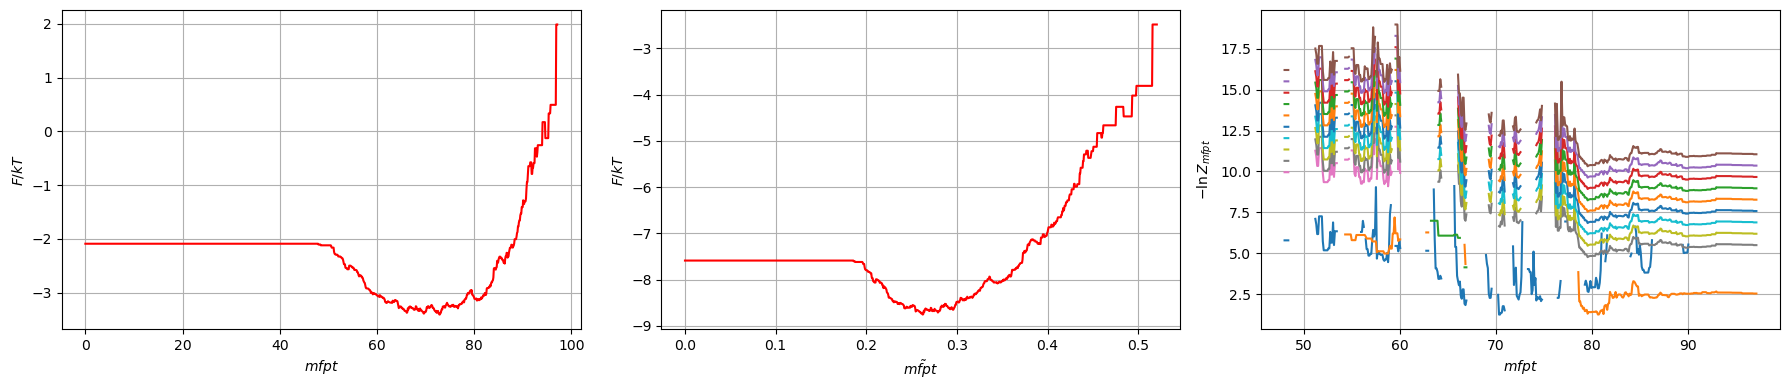

In [17]:
q=OptimalRCs.MFPTNE(IndA=IndA, i_traj=ptrajne_r, t_traj=ttrajne_r)
np.random.seed(0)
q.fit_transform(comp_y,dxmin=1e-4)
q.plots(dt_sim=0.0005)
plt.savefig("from birth plots with default hyperparameters.svg", format='svg', dpi=1200)

The trajectories are very short because there are few samples per individual.

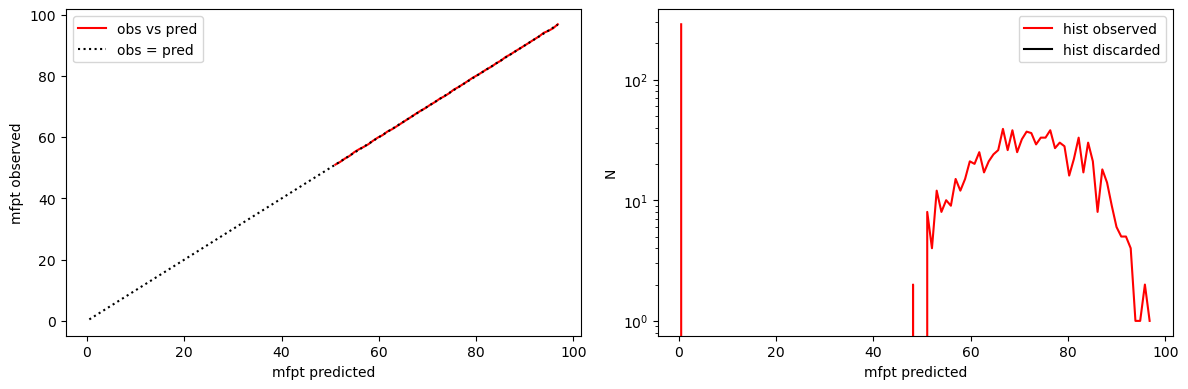

In [18]:
q.plot_obs_pred()
plt.savefig("from birth obs_pred plots with default hyperparameters.svg", format='svg', dpi=1200)

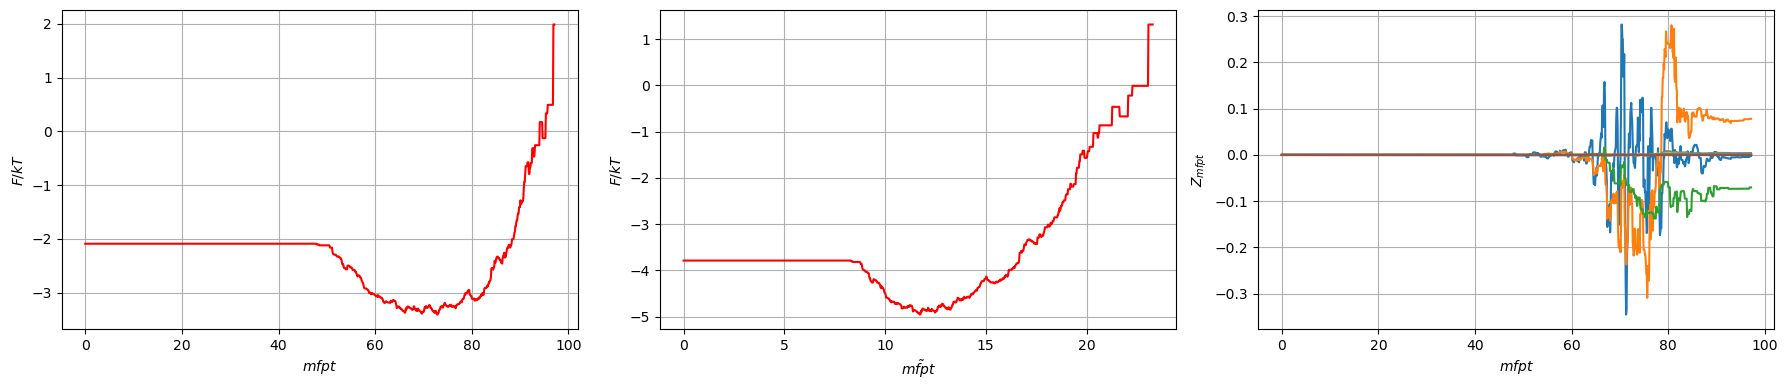

In [19]:
q.plots(lnzmfpt=False)
plt.savefig("from birth plots lnzmfpt=False with default hyperparameters.svg", format='svg', dpi=1200)

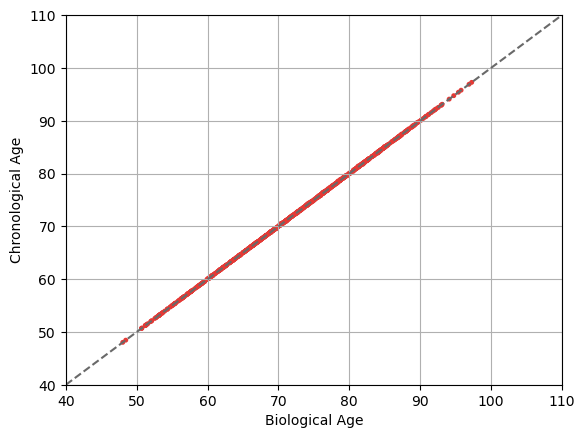

In [20]:
plt.scatter(q.r, ttrajne[::-1], edgecolor="none",
        s=50, color="#E53935", marker=".")
plt.ylim(40, 110)
plt.xlim(40, 110)
plt.xlabel("Biological Age")
plt.ylabel("Chronological Age")
plt.axline((0, 0), slope=1, linestyle= '--', color='dimgrey')
plt.grid(True)
#plt.show()
plt.savefig("mfpt biological vs chronological with default hyperparameters.svg", format='svg', dpi=1200)

The perfect agreement between biological and chronological age, suggesting overfitting. 

I could adjust ny and evelope scale to adjust the flexibility. ny is the degree of polynomial basis functions for variation. For small dataset, it is best to keep it small. When ny (degree of polynomial basis functions) is large, the optimisation has too much freedom to fit the trajectories, making it overly complex. This can lead to a reaction coordinate that perfectly aligns with the data but it would then fail to generalise across different trajectories or individuals. Envelope scale is used to improve uniformity for deep minima. However, I don't have deep minima here, so I will set it high. I can also adjust gamma, where a higher gamma makes the analysis more stable but less exploratory. Gamma is usually for penalisation (regularisation), is that also the case here? Therefore, it also discourages overfitting 

Parameters:
- ny=4
- gamma=0
- Envelope_scale=0.01

Here, I played with different values of ny to see at which value overfitting occurs. I found that when ny=>4, there was overfitting

iteration 0, loss=-1868.64, delta_r=91.3079, |dx|=0.729777, time=0.052439
iteration 1000, loss=-1840.01, delta_r=94.6948, |dx|=0.0914333, time=1.74127
iteration 2000, loss=-1839.34, delta_r=95.6501, |dx|=0.0147703, time=3.4617
iteration 3000, loss=-1838.85, delta_r=95.1248, |dx|=0.00893694, time=5.10557
iteration 4000, loss=-1838.71, delta_r=95.8321, |dx|=0.00673737, time=6.74487
iteration 5000, loss=-1838.58, delta_r=95.7968, |dx|=0.00477938, time=8.38381
iteration 6000, loss=-1838.24, delta_r=96.1945, |dx|=0.00463485, time=10.0235
iteration 7000, loss=-1838.06, delta_r=95.9056, |dx|=0.00349561, time=11.6552
iteration 8000, loss=-1837.77, delta_r=96.0518, |dx|=0.00305309, time=13.3061
iteration 9000, loss=-1837.51, delta_r=95.8293, |dx|=0.0026409, time=14.9505
iteration 10000, loss=-1837.35, delta_r=96.444, |dx|=0.00237814, time=16.5591
iteration 11000, loss=-1837.26, delta_r=96.4859, |dx|=0.00249988, time=18.2119
iteration 12000, loss=-1836.98, delta_r=96.2062, |dx|=0.00226876, time=

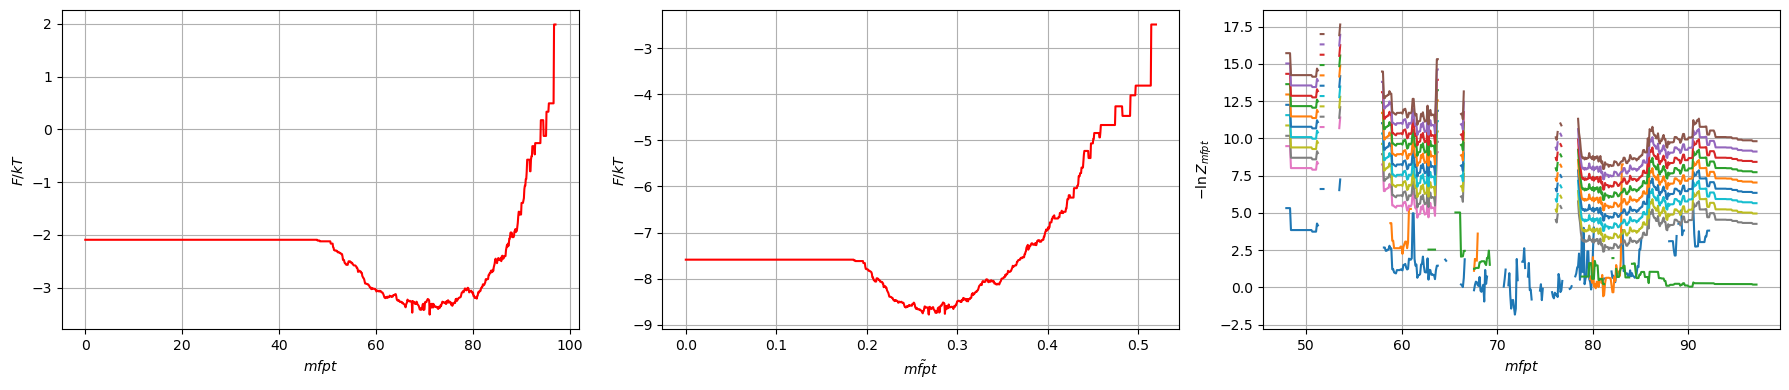

In [21]:
q=OptimalRCs.MFPTNE(IndA=IndA, i_traj=ptrajne_r, t_traj=ttrajne_r)
np.random.seed(0)
q.fit_transform(comp_y,dxmin=1e-4, ny=3)
q.plots(dt_sim=0.0005)

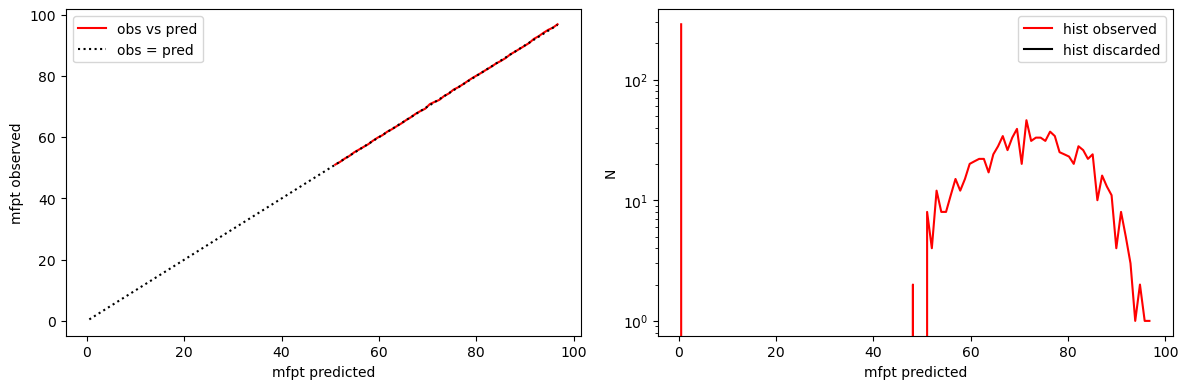

In [22]:
q.plot_obs_pred()

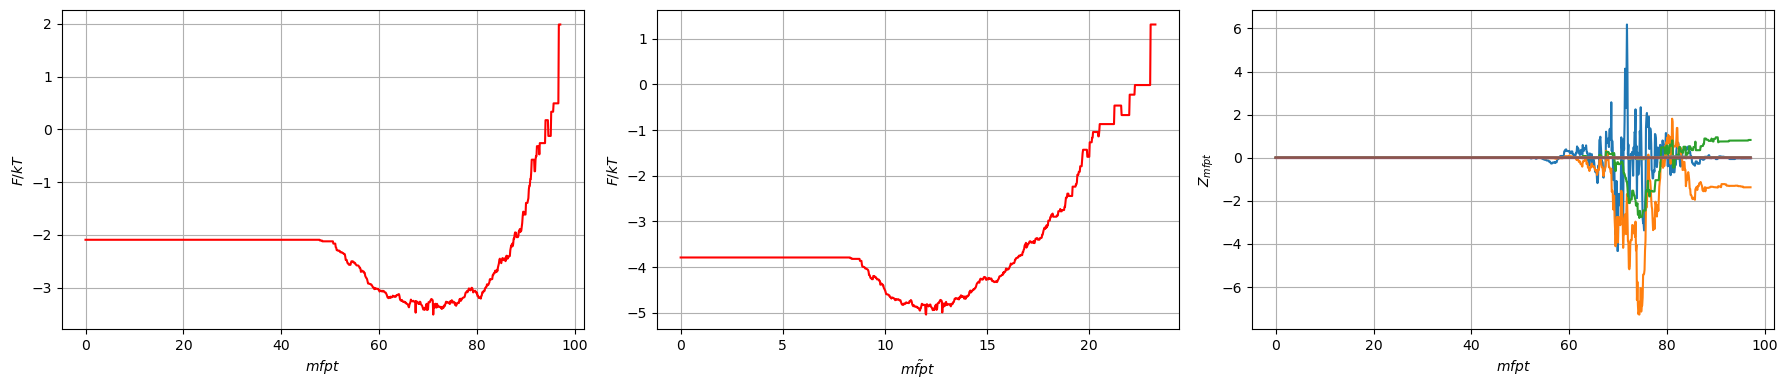

In [23]:
q.plots(lnzmfpt=False)

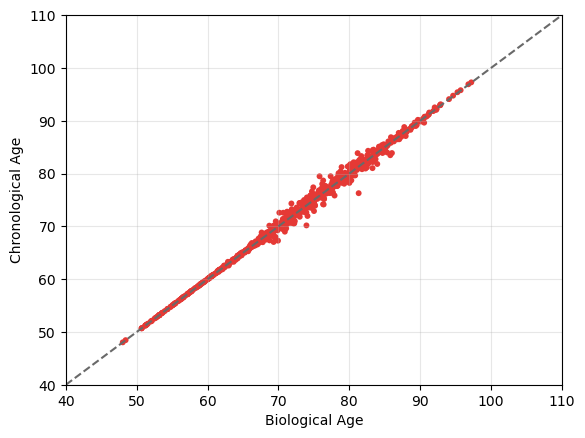

In [24]:
plt.scatter(q.r, ttrajne[::-1], edgecolor="none",
        s=18, color="#E53935")
plt.ylim(40, 110)
plt.xlim(40, 110)
plt.xlabel("Biological Age")
plt.ylabel("Chronological Age")
plt.axline((0, 0), slope=1, linestyle= '--', color='dimgrey')
plt.grid(True, alpha=0.3)
plt.show()

Parameters:
- envelope_scale=0.01
- ny=6
- gamma=0.1

iteration 0, loss=-42.4278, delta_r=1, |dx|=0, time=0.0525239
iteration 1000, loss=-1847.06, delta_r=94.7142, |dx|=0.674207, time=2.67728
iteration 2000, loss=-1846.62, delta_r=94.7162, |dx|=0.00699894, time=4.91928
iteration 3000, loss=-1846.19, delta_r=94.9787, |dx|=0.00391932, time=6.84719
iteration 4000, loss=-1845.65, delta_r=94.2876, |dx|=0.00375698, time=9.6261
iteration 5000, loss=-1845.43, delta_r=94.1203, |dx|=0.00313281, time=12.3913
iteration 6000, loss=-1845.47, delta_r=93.4719, |dx|=0.00265834, time=15.0949
iteration 7000, loss=-1845.05, delta_r=93.1252, |dx|=0.00248036, time=17.8669
iteration 8000, loss=-1844.94, delta_r=93.2938, |dx|=0.00217635, time=20.5953
iteration 9000, loss=-1845.05, delta_r=93.222, |dx|=0.00180221, time=23.1165
iteration 10000, loss=-1844.76, delta_r=93.2193, |dx|=0.00161024, time=24.8285
iteration 11000, loss=-1844.66, delta_r=93.3399, |dx|=0.00148797, time=27.488
iteration 12000, loss=-1844.42, delta_r=93.5337, |dx|=0.00133399, time=30.243
itera

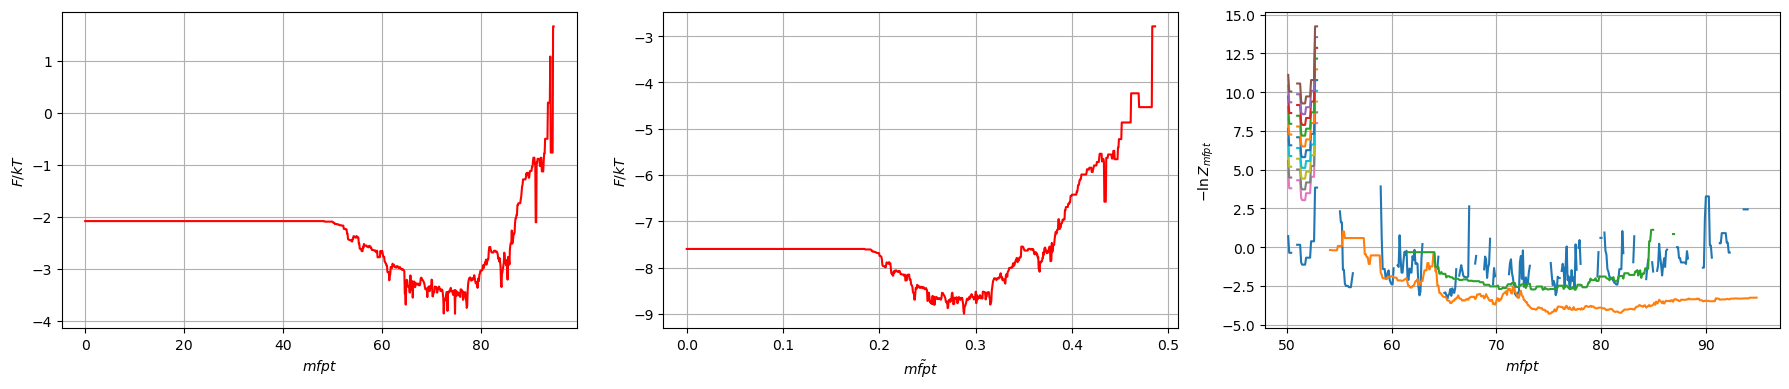

In [25]:
OptimalRCs.envelope_scale=0.01

q=OptimalRCs.MFPTNE(IndA=IndA, i_traj=ptrajne_r, t_traj=ttrajne_r)
np.random.seed(0)
q.fit_transform(comp_y,dxmin=1e-4, ny=6, gamma=0.1)
q.plots(dt_sim=0.0005)
plt.savefig("from birth plots with tuned hyperparameters.svg", format='svg', dpi=1200)

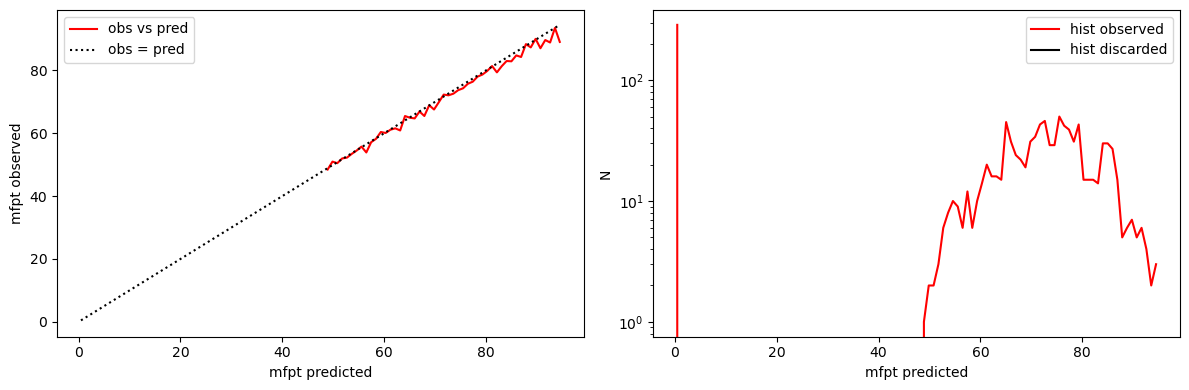

In [26]:
q.plot_obs_pred()
plt.savefig("from birth obs_pred plots with tuned hyperparameters.svg", format='svg', dpi=1200)

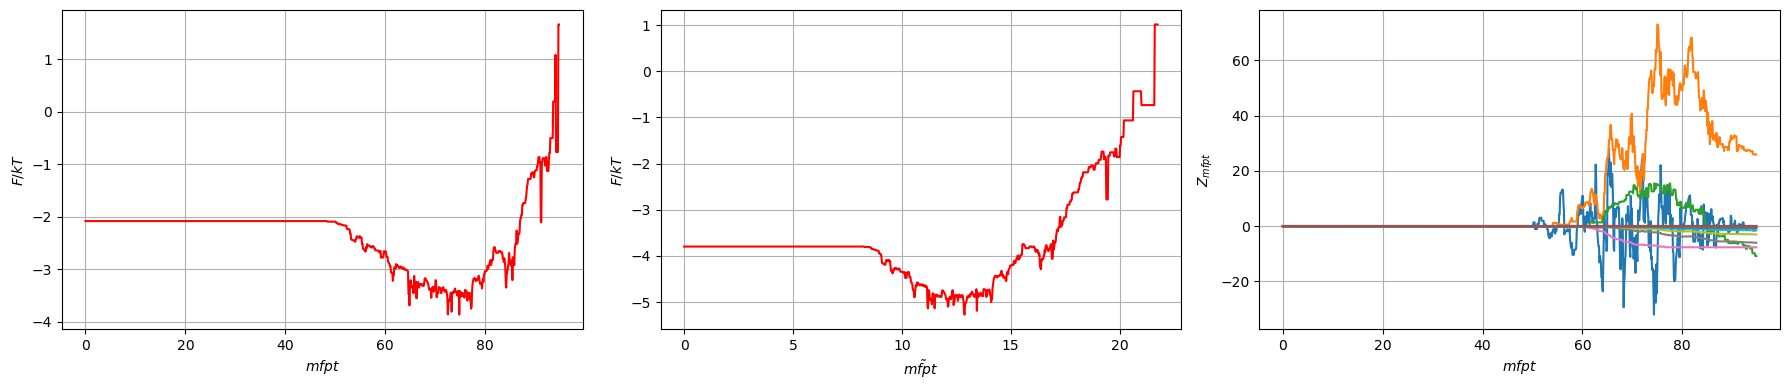

In [27]:
q.plots(lnzmfpt=False)
plt.savefig("from birth plots lnzmfpt=False with tuned hyperparameters.svg", format='svg', dpi=1200)

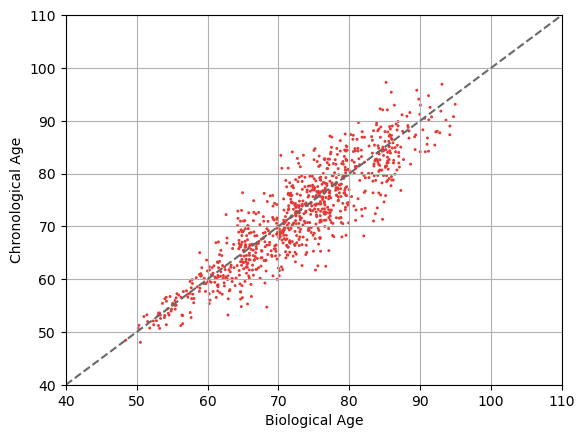

In [28]:
biological = q.r
chronological = ttrajne[::-1]

plt.scatter(biological, chronological, edgecolor="none",
        s=18, color="#E53935", marker='.')

plt.ylim(40, 110)
plt.xlim(40, 110)
plt.xlabel("Biological Age")
plt.ylabel("Chronological Age")
plt.axline((0, 0), slope=1, linestyle= '--', color='dimgrey')
plt.grid(True)
#plt.show()
plt.savefig("mfpt biological vs chronological with tuned hyperparameters.svg", format='svg', dpi=1200)

Adding gamma=0.1 removed overfitting, and I confirmed this was robust by changing the random seed multiple times. 

For the RBF kernel SVM, I computed the biological ageing rate. I can do this for MFPT also, allowing them to be compared. 

In [33]:
predictions_actual = pd.DataFrame({
    "ID": ptrajne_r,
    "chronological_age": chronological,
    "biological_age": biological
})
predictions_actual = predictions_actual[predictions_actual['chronological_age'] != 0]
predictions_actual.head(10)

ID  chronological_age  biological_age
0   444.0          63.279945       64.927006
1   444.0          61.034908       59.024615
2   444.0          56.449009       55.548779
3   444.0          53.083332       56.486788
5   443.0          63.279945       65.380439
6   443.0          61.371662       63.195651
7   443.0          56.531143       61.224479
8   443.0          53.236301       51.432327
10  442.0          54.362766       54.317253
11  442.0          51.355247       52.388113

In [37]:
import statsmodels.api as sm

biological_ageing_rate = []

for subject, group in predictions_actual.groupby("ID"):
    X = sm.add_constant(group["chronological_age"])
    y = group["biological_age"]
    model = sm.OLS(y, X).fit()
    
    slope = model.params["chronological_age"]  # biological ageing rate
    
    # Baseline biological age (earliest chronological age for this subject)
    baseline_bio_age = group.loc[group["chronological_age"].idxmin(), "biological_age"]
    
    biological_ageing_rate.append({
        "ID": subject,
        "ageing_rate": slope,
        "baseline_bio_age": baseline_bio_age
    })

biological_ageing_rate = pd.DataFrame(biological_ageing_rate)
biological_ageing_rate.head(50)

ID  ageing_rate  baseline_bio_age
0     4.0     1.095771         65.960033
1     5.0     0.820376         73.327650
2     8.0     0.802029         65.288037
3     9.0     0.866923         64.520948
4    10.0     1.173954         71.012197
5    11.0     0.532993         62.735665
6    12.0     1.178698         63.523955
7    13.0     0.881680         72.703152
8    25.0    -0.349967         86.769521
9    34.0     1.337307         83.414742
10   39.0     0.982011         78.433853
11   42.0     0.992861         80.377669
12   45.0     1.494981         85.021141
13   50.0     0.737624         80.689410
14   51.0     0.733871         86.164032
15   54.0     0.105901         83.249540
16   55.0     0.948233         75.929808
17   67.0     1.164846         83.206776
18   68.0     1.323986         76.324141
19   72.0     0.717185         73.737754
20   73.0     1.108304         76.357572
21   75.0     0.696703         79.453361
22   76.0     0.305952         84.791293
23   77.0     0.926085         77.579672
24   79.0     0.673633         78.171861
25   80.0     0.925952         79.961122
26   85.0     0.342368         86.469562
27   86.0     0.476989         78.133324
28   89.0     0.300511         76.614156
29   90.0     0.952945         75.101404
30   91.0     0.940237         78.111748
31   92.0     0.983004         79.612269
32   95.0     0.485589         78.363490
33   97.0     0.350840         82.255598
34  101.0     1.512611         71.160204
35  102.0    -1.368434         92.915492
36  103.0     0.379898         75.527300
37  104.0     0.528217         79.633684
38  105.0     0.479273         76.163328
39  107.0     0.471744         78.060410
40  108.0     1.120907         77.234996
41  110.0     1.111661         79.296884
42  116.0     1.096813         82.156017
43  119.0     0.874216         75.108750
44  121.0     0.852933         75.825541
45  125.0    -0.053363         79.799281
46  126.0     0.864498         75.328433
47  128.0     1.081525         76.478144
48  131.0     0.150623         71.611771
49  132.0     0.808884         86.066044

Parameters:
- envelope_scale=1000000
- ny=6
- gamma=0

By only increasing envelope_scale to 1000000, this appeared to remove overfitting; however, had there been more iterations, overfitting could have occurred eventually. 

iteration 0, loss=-1868.35, delta_r=86.7539, |dx|=0.767731, time=0.00535536
iteration 1000, loss=-1839.22, delta_r=99.1165, |dx|=0.0892743, time=1.29051
iteration 2000, loss=-1839.11, delta_r=98.5788, |dx|=0.00923636, time=2.55091
iteration 3000, loss=-1839.01, delta_r=97.7779, |dx|=0.00415229, time=3.80436
iteration 4000, loss=-1838.92, delta_r=97.4466, |dx|=0.00322068, time=5.0571
iteration 5000, loss=-1838.78, delta_r=97.031, |dx|=0.00266198, time=6.33012
iteration 6000, loss=-1838.7, delta_r=96.6102, |dx|=0.00224017, time=7.60306
iteration 7000, loss=-1838.52, delta_r=96.5583, |dx|=0.0018462, time=8.87839
iteration 8000, loss=-1838.35, delta_r=96.615, |dx|=0.00154669, time=10.1332
iteration 9000, loss=-1838.22, delta_r=96.5544, |dx|=0.0013249, time=11.4122
iteration 10000, loss=-1838.11, delta_r=96.8112, |dx|=0.00122421, time=12.6928
iteration 11000, loss=-1838.01, delta_r=96.8485, |dx|=0.00113696, time=13.9757
iteration 12000, loss=-1837.93, delta_r=96.9996, |dx|=0.00107124, time=

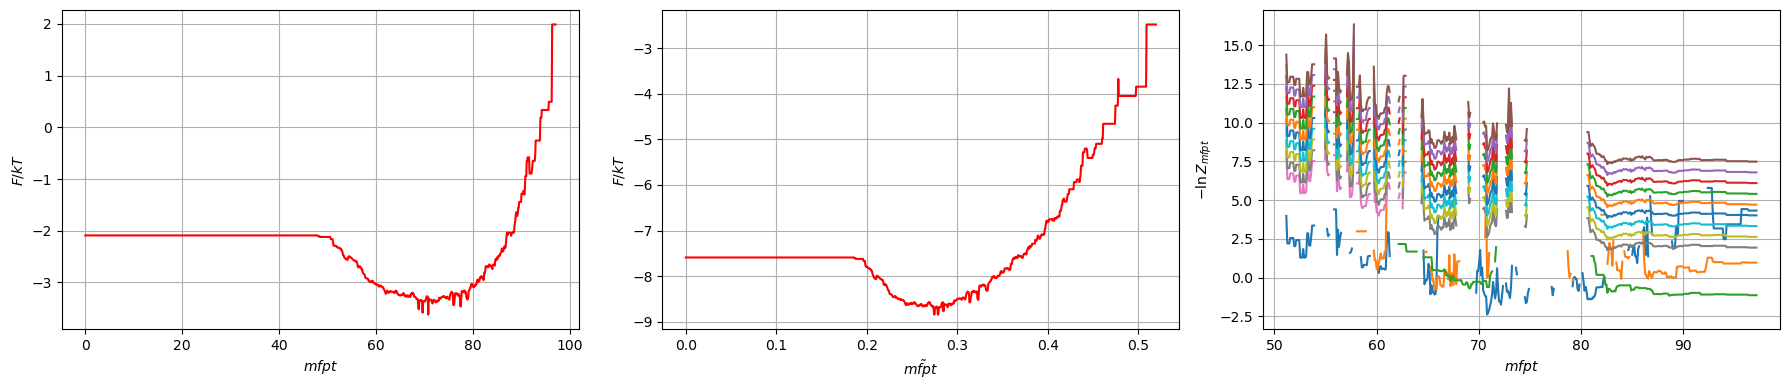

In [288]:
OptimalRCs.envelope_scale=1000000

q=OptimalRCs.MFPTNE(IndA=IndA, i_traj=ptrajne_r, t_traj=ttrajne_r)
np.random.seed(0)
q.fit_transform(comp_y,dxmin=1e-4, ny=6)
q.plots(dt_sim=0.0005)

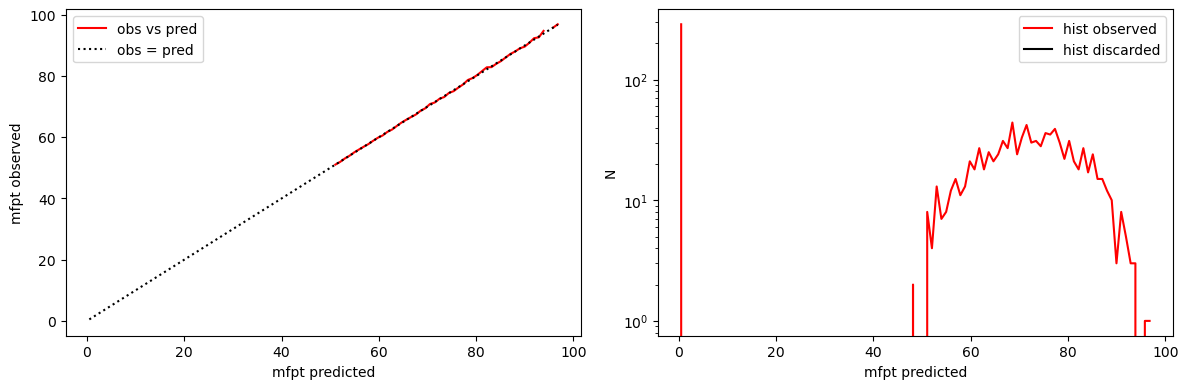

In [289]:
q.plot_obs_pred()

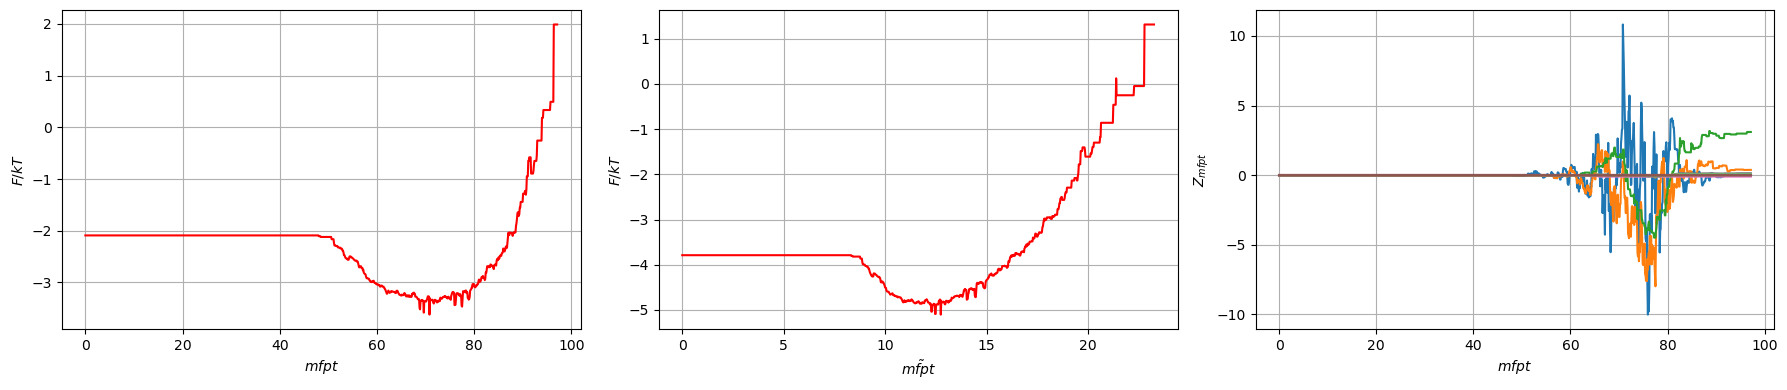

In [290]:
q.plots(lnzmfpt=False)

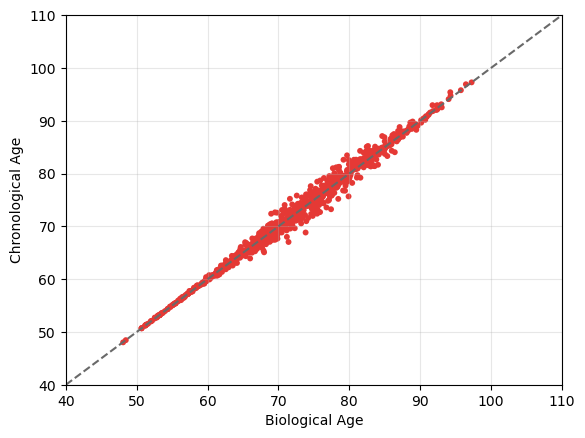

In [291]:
plt.scatter(q.r, ttrajne[::-1], edgecolor="none",
        s=18, color="#E53935")
plt.ylim(40, 110)
plt.xlim(40, 110)
plt.xlabel("Biological Age")
plt.ylabel("Chronological Age")
plt.axline((0, 0), slope=1, linestyle= '--', color='dimgrey')
plt.grid(True, alpha=0.3)
plt.show()

Parameters:
- envelope_scale=1000000
- ny=6
- gamma=0.1

iteration 0, loss=-1794.71, delta_r=87.4002, |dx|=0.677505, time=0.00490475
iteration 1000, loss=-1850.95, delta_r=95.5184, |dx|=0.0955991, time=1.31649
iteration 2000, loss=-1849.17, delta_r=93.8518, |dx|=0.00828561, time=2.60851
iteration 3000, loss=-1848.23, delta_r=93.2593, |dx|=0.00466246, time=3.90285
iteration 4000, loss=-1847.69, delta_r=92.9943, |dx|=0.00259707, time=5.18918
iteration 5000, loss=-1847.23, delta_r=92.9101, |dx|=0.00171291, time=6.47004
iteration 6000, loss=-1847.07, delta_r=92.9112, |dx|=0.00111587, time=7.75137
iteration 7000, loss=-1846.85, delta_r=92.9597, |dx|=0.000908073, time=9.03535
iteration 8000, loss=-1846.69, delta_r=92.9436, |dx|=0.000774257, time=10.3175
iteration 9000, loss=-1846.58, delta_r=92.9757, |dx|=0.000676479, time=11.6158
iteration 10000, loss=-1846.54, delta_r=93.0379, |dx|=0.000587986, time=12.8952
iteration 11000, loss=-1846.49, delta_r=93.0754, |dx|=0.000551419, time=14.1833
iteration 12000, loss=-1846.4, delta_r=93.1243, |dx|=0.00050

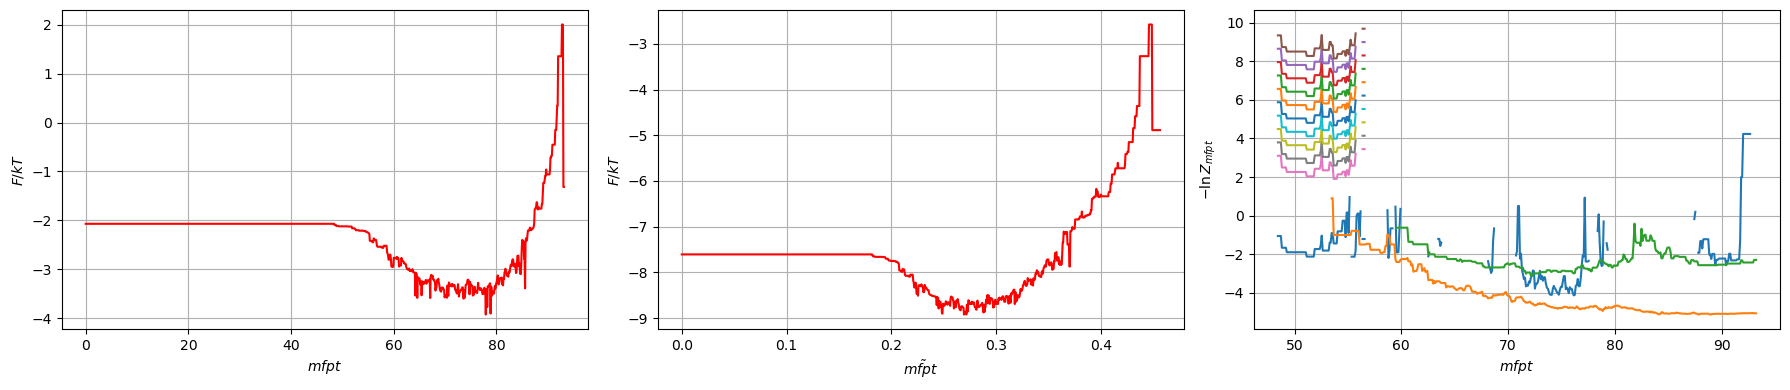

In [292]:
OptimalRCs.envelope_scale=10000

q=OptimalRCs.MFPTNE(IndA=IndA, i_traj=ptrajne_r, t_traj=ttrajne_r)
np.random.seed(0)
q.fit_transform(comp_y,dxmin=1e-4, ny=6, gamma=0.1)
q.plots(dt_sim=0.0005)

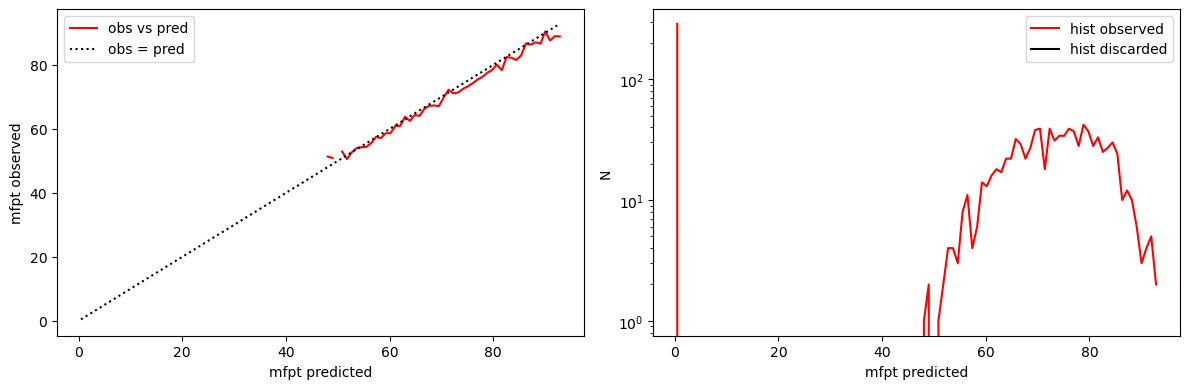

In [293]:
q.plot_obs_pred()

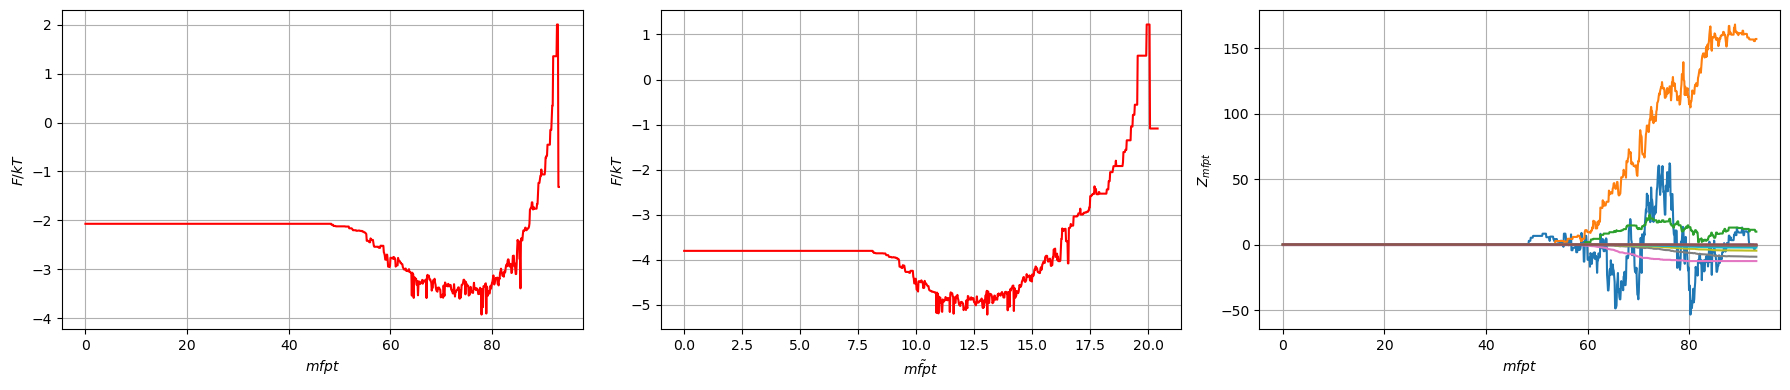

In [294]:
q.plots(lnzmfpt=False)

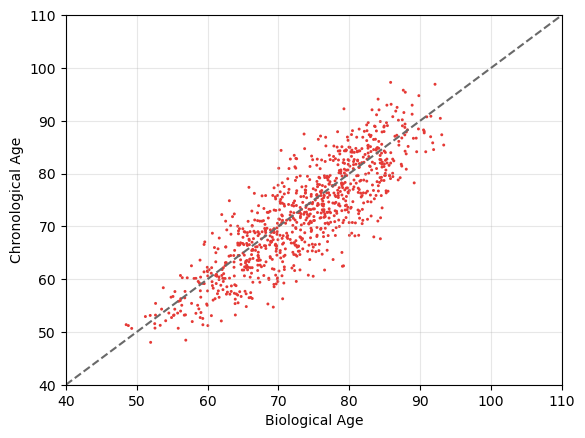

In [295]:
plt.scatter(q.r, ttrajne[::-1], edgecolor="none",
        s=18, color="#E53935", marker=".")
plt.ylim(40, 110)
plt.xlim(40, 110)
plt.xlabel("Biological Age")
plt.ylabel("Chronological Age")
plt.axline((0, 0), slope=1, linestyle= '--', color='dimgrey')
plt.grid(True, alpha=0.3)
plt.show()

Therefore, it appears that adding a penalty through gamma=0.1 removes overfitting.

Next, for gamma=0.1, I will show the plots of obtained times q.r and compare them with chronological age again and then show specific cases where the overall trends are exemplified. 

In [296]:
q.r

<tf.Tensor: shape=(1201,), dtype=float64, numpy=
array([65.81177655, 62.26662808, 56.77645121, ..., 73.06614273,
       65.89063904,  0.        ], shape=(1201,))>

In [297]:
ttrajne[::-1] 

array([63.279945, 61.03491 , 56.44901 , ..., 73.56849 , 66.530136,
        0.      ], shape=(1201,), dtype=float32)

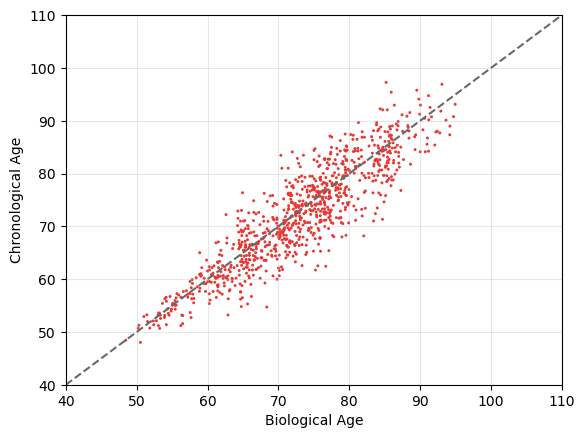

In [298]:
plt.scatter(biological, chronological, edgecolor="none",
        s=18, color="#E53935", marker=".")
plt.ylim(40, 110)
plt.xlim(40, 110)
plt.xlabel("Biological Age")
plt.ylabel("Chronological Age")
plt.axline((0, 0), slope=1, linestyle= '--', color='dimgrey')
plt.grid(True, alpha=0.3)
plt.show()

This plot of biological vs chronological age shows that it is a good predictor of chronological age but there are also deviations from chronological age, suggesting differences between an individuals physiological status and their chronological age.

Metric calculation to compare to ML model: 

In [38]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

In [39]:
print("Performance")
print("RMSE:", np.sqrt(mean_squared_error(np.array(chronological), np.array(biological))))
print("MAE:", mean_absolute_error(np.array(chronological), np.array(biological)))
print("Pearson r:", pearsonr(np.array(chronological), np.array(biological))[0])
print("R2:", r2_score(np.array(chronological), np.array(biological)))

Performance
RMSE: 3.8516597803451886
MAE: 2.6074043280589323
Pearson r: 0.9929977062847006
R2: 0.9854619825476489


MFPT predictive performance was much better than the RBF kernel SVM which achieved a test RMSE of 5.71 years, MAE of 4.55 years, r of 0.81 and $R^2$ of 0.64. 

I can plot the biological age predictions across samples for an individual:

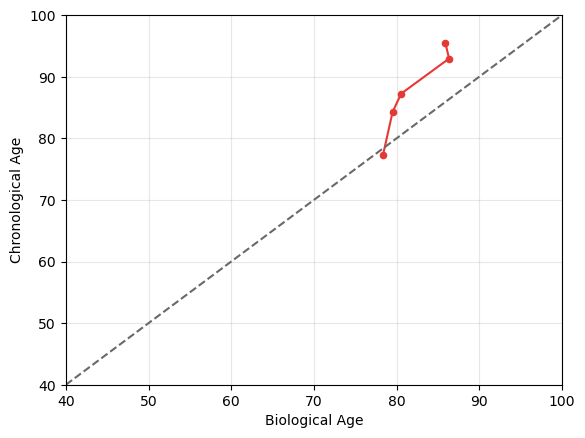

In [40]:
plt.scatter(biological[1077:1082], chronological[1077:1082], s=20, color='#E53935', zorder=10)
plt.plot(biological[1077:1082], chronological[1077:1082], color = '#E53935')
plt.ylim(40, 100)
plt.xlim(40, 100)
plt.xlabel("Biological Age")
plt.ylabel("Chronological Age")
plt.axline((0, 0), slope=1, linestyle= '--', color='dimgrey')
plt.grid(True, alpha=0.3)
plt.show()

This plot shows biological vs chronological age for one individual at different time points. While initially their biological age was lower than their chronological age, as their chronological age increases, their biological age deviates from their chronological age. Specifically, their biological age is lower than their chronological age, suggesting that they are getting biologically younger.  

Next, I want to compare the biological and chronological age from both SVR and mfpt: 

I will run the SVR model so that I can access the predicted values

In [41]:
import joblib

X, y = significant.drop(columns=['ID', 'Age']), significant['Age']

# Load the splits 
splits = joblib.load("cv_10splits.pkl")

In [42]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

rbf_svr = SVR(kernel='rbf', C=3, gamma=0.01)

test_ids = []

# Store metrics
train_r2_scores, test_r2_scores = [], []
train_mse_scores, test_mse_scores = [], []

# Store predictions and actual values
y_preds_train, y_actual_train = [], []
y_preds_test, y_actual_test = [], []

for fold_idx, (train_idx, test_idx) in enumerate(splits):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    ids_test = significant.iloc[test_idx]['ID'].values

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test) 
    
    rbf_svr.fit(X_train, y_train)
    y_pred_train = rbf_svr.predict(X_train)
    y_pred_test = rbf_svr.predict(X_test)

    # Save predictions for plotting
    y_preds_train.extend(y_pred_train)
    y_actual_train.extend(y_train)
    y_preds_test.extend(y_pred_test)
    y_actual_test.extend(y_test)
    test_ids.extend(ids_test)


    # Compute r2 and MSE metrics to evaluate regression models 
    train_r2_scores.append(r2_score(y_train, y_pred_train))
    test_r2_scores.append(r2_score(y_test, y_pred_test))
    train_mse_scores.append(mean_squared_error(y_train, y_pred_train))
    test_mse_scores.append(mean_squared_error(y_test, y_pred_test))

y_preds_train = np.array(y_preds_train)
y_actual_train = np.array(y_actual_train)
y_preds_test = np.array(y_preds_test)
y_actual_test = np.array(y_actual_test)
test_ids = np.array(test_ids)

print("Average train R2:", np.mean(train_r2_scores))
print("Average test R2:", np.mean(test_r2_scores))
print("Average train MSE:", np.mean(train_mse_scores))
print("Average test MSE:", np.mean(test_mse_scores))

Average train R2: 0.732448131054532
Average test R2: 0.6433543223785754
Average train MSE: 25.38047684985449
Average test MSE: 32.79859262266822


Calculating biological age acceleration for RBF kernel SVM as I did in the previous notebook so I can compare to MFPT:

In [44]:
predictions_actual_svm = pd.DataFrame({
    "ID": test_ids,
    "chronological_age": y_actual_test,
    "biological_age": y_preds_test
})
predictions_actual_svm.head(10)

ID  chronological_age  biological_age
0   5          84.531143       85.633451
1  10          74.347030       74.380469
2  13          72.777394       74.521013
3  28          90.062300       80.183886
4  30          90.582330       82.016925
5  37          80.224195       75.760913
6  45          87.946800       83.862171
7  50          80.053200       81.922592
8  55          88.900753       81.868989
9  55          96.906229       80.698085

In [56]:
import statsmodels.api as sm

biological_ageing_rate_svm = []

for subject, group in predictions_actual_svm.groupby("ID"):
    X = sm.add_constant(group["chronological_age"])
    y = group["biological_age"]
    model = sm.OLS(y, X).fit()
    
    slope = model.params["chronological_age"]  # biological ageing rate
    
    # Baseline biological age (earliest chronological age for this subject)
    baseline_bio_age = group.loc[group["chronological_age"].idxmin(), "biological_age"]
    
    biological_ageing_rate_svm.append({
        "ID": subject,
        "ageing_rate": slope,
        "baseline_bio_age": baseline_bio_age
    })

biological_ageing_rate_svm = pd.DataFrame(biological_ageing_rate_svm)
biological_ageing_rate_svm.head(30)

ID  ageing_rate  baseline_bio_age
0    1     0.913571         82.131308
1    2     0.896358         84.257682
2    3     0.868985         85.055729
3    4     0.987987         62.444563
4    5     0.653653         74.077560
5    6     0.987726         66.786312
6    7     0.955315         64.024442
7    8     0.734151         65.335729
8    9     0.704467         64.387783
9   10     1.079451         66.959866
10  11     0.114885         64.819556
11  12     0.677022         70.404210
12  13     0.623317         74.521013
13  14     0.894617         77.805698
14  15     0.944675         81.529352
15  16     1.007804         85.641258
16  17     0.931109         79.478409
17  18     1.027860         83.583291
18  19     0.927747         82.840649
19  20     0.971347         85.347073
20  21     0.899207         77.279036
21  22     0.889470         77.393649
22  23     0.888010         82.575907
23  24     0.976028         84.615840
24  25    -0.710402         83.724340
25  26     0.816095         75.879106
26  27     0.879197         81.948415
27  28     0.890316         80.183886
28  29     0.810478         67.550934
29  30     0.905441         82.016925

In [65]:
# Merge the two dataframes on ID
merged = pd.merge(biological_ageing_rate_svm, biological_ageing_rate, on="ID", how="inner")  # keep only IDs present in both
merged

ID  ageing_rate_x  baseline_bio_age_x  ageing_rate_y  baseline_bio_age_y
0      4       0.987987           62.444563       1.095771           65.960033
1      5       0.653653           74.077560       0.820376           73.327650
2      8       0.734151           65.335729       0.802029           65.288037
3      9       0.704467           64.387783       0.866923           64.520948
4     10       1.079451           66.959866       1.173954           71.012197
..   ...            ...                 ...            ...                 ...
282  439       1.052939           55.367178       0.830221           56.478738
283  440      -0.293422           56.330272      -0.252877           56.216904
284  442      -0.316576           61.017729       0.641439           52.388113
285  443       0.118166           55.872804       1.236605           51.432327
286  444       0.542748           60.261895       0.781415           56.486788

[287 rows x 5 columns]

In [63]:
merged['mfpt_larger_magnitude'] = merged['ageing_rate_y'].abs() > merged['ageing_rate_x'].abs()

num_larger_mag = merged['mfpt_larger_magnitude'].sum()
print(f"MFPT ageing rate has larger magnitude in {num_larger_mag}/{num_total} subjects ({num_larger_mag/num_total:.2%})")

MFPT ageing rate has larger magnitude in 202/287 subjects (70.38%)


In [67]:
merged['rate_difference'] = merged['ageing_rate_y'] - merged['ageing_rate_x']

# Check how many are positive or negative
num_positive = (merged['rate_difference'] > 0).sum()
num_negative = (merged['rate_difference'] < 0).sum()
num_positive, num_negative

(np.int64(215), np.int64(72))

In [68]:
r, p = pearsonr(merged['ageing_rate_y'], merged['ageing_rate_x'])
print(f"Pearson r = {r:.3f}, p = {p:.3e}")

Pearson r = 0.562, p = 2.710e-25


There is a positive correlation between the biological ageing rates from SVM and MFPT. 

Next, I want to compare the biological age predictions from MFPT and SVM. First, I will plot the chronological age of five individuals (95, 172, 310, 354, 359, 403) against their biological age determined from SVM and mfpt 

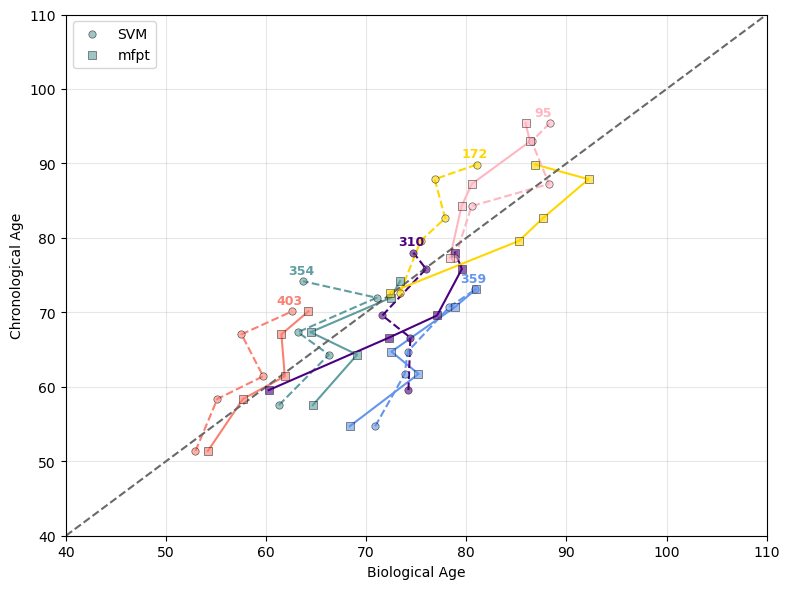

In [303]:
plt.figure(figsize=(8, 6))

individuals = [
    {"id": 354, "idx": slice(376, 381), "color": "cadetblue"},
    {"id": 359, "idx": slice(351, 356), "color": "cornflowerblue"},
    {"id": 310, "idx": slice(515, 520), "color": "indigo"},
    {"id": 403, "idx": slice(163, 168), "color": "salmon"},
    {"id": 172, "idx": slice(933, 938), "color": "gold"},
    {"id": 95, "idx": slice(1077, 1082), "color": "lightpink"}
]

for i, person in enumerate(individuals):
    color = person["color"]
    label_svm = "SVM" if i == 0 else None
    label_mfpt = "mfpt" if i == 0 else None

    # Extract individual data
    mask = test_ids == person["id"]
    y_pred = y_preds_test[mask]  # biological age (x)
    y_actual = y_actual_test[mask]  # chronological age (y)

    # Sort both arrays by chronological age (y)
    sorted_idx = np.argsort(y_actual)
    y_pred_sorted = y_pred[sorted_idx]
    y_actual_sorted = y_actual[sorted_idx]

    # Scatter and line (in sorted order)
    plt.scatter(
        y_pred_sorted, y_actual_sorted,
        s=28, label=label_svm, color=color, alpha=0.6, zorder=10,
        edgecolor="black", linewidth=0.5
    )
    plt.plot(y_pred_sorted, y_actual_sorted, color=color, linestyle='--')

    # Label individuals 
    plt.text(
        y_pred_sorted[-1]- 1.5, y_actual_sorted[-1] + 1, 
        str(person["id"]), color=color,
        fontsize=9, weight='bold', zorder=20
    )
    
    # Plot and connect MFPT points
    plt.scatter(
        biological[person["idx"]], chronological[person["idx"]],
        s=28, label=label_mfpt, marker='s', color=color, alpha=0.6, zorder=10,
        edgecolor="black", linewidth=0.5
    )
    plt.plot(biological[person["idx"]], chronological[person["idx"]], color=color)

plt.axline((0, 0), slope=1, linestyle='--', color='dimgrey')
plt.ylim(40, 110)
plt.xlim(40, 110)
plt.xlabel("Biological Age")
plt.ylabel("Chronological Age")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(loc="upper left")
plt.show()

Plot for twenty individuals:

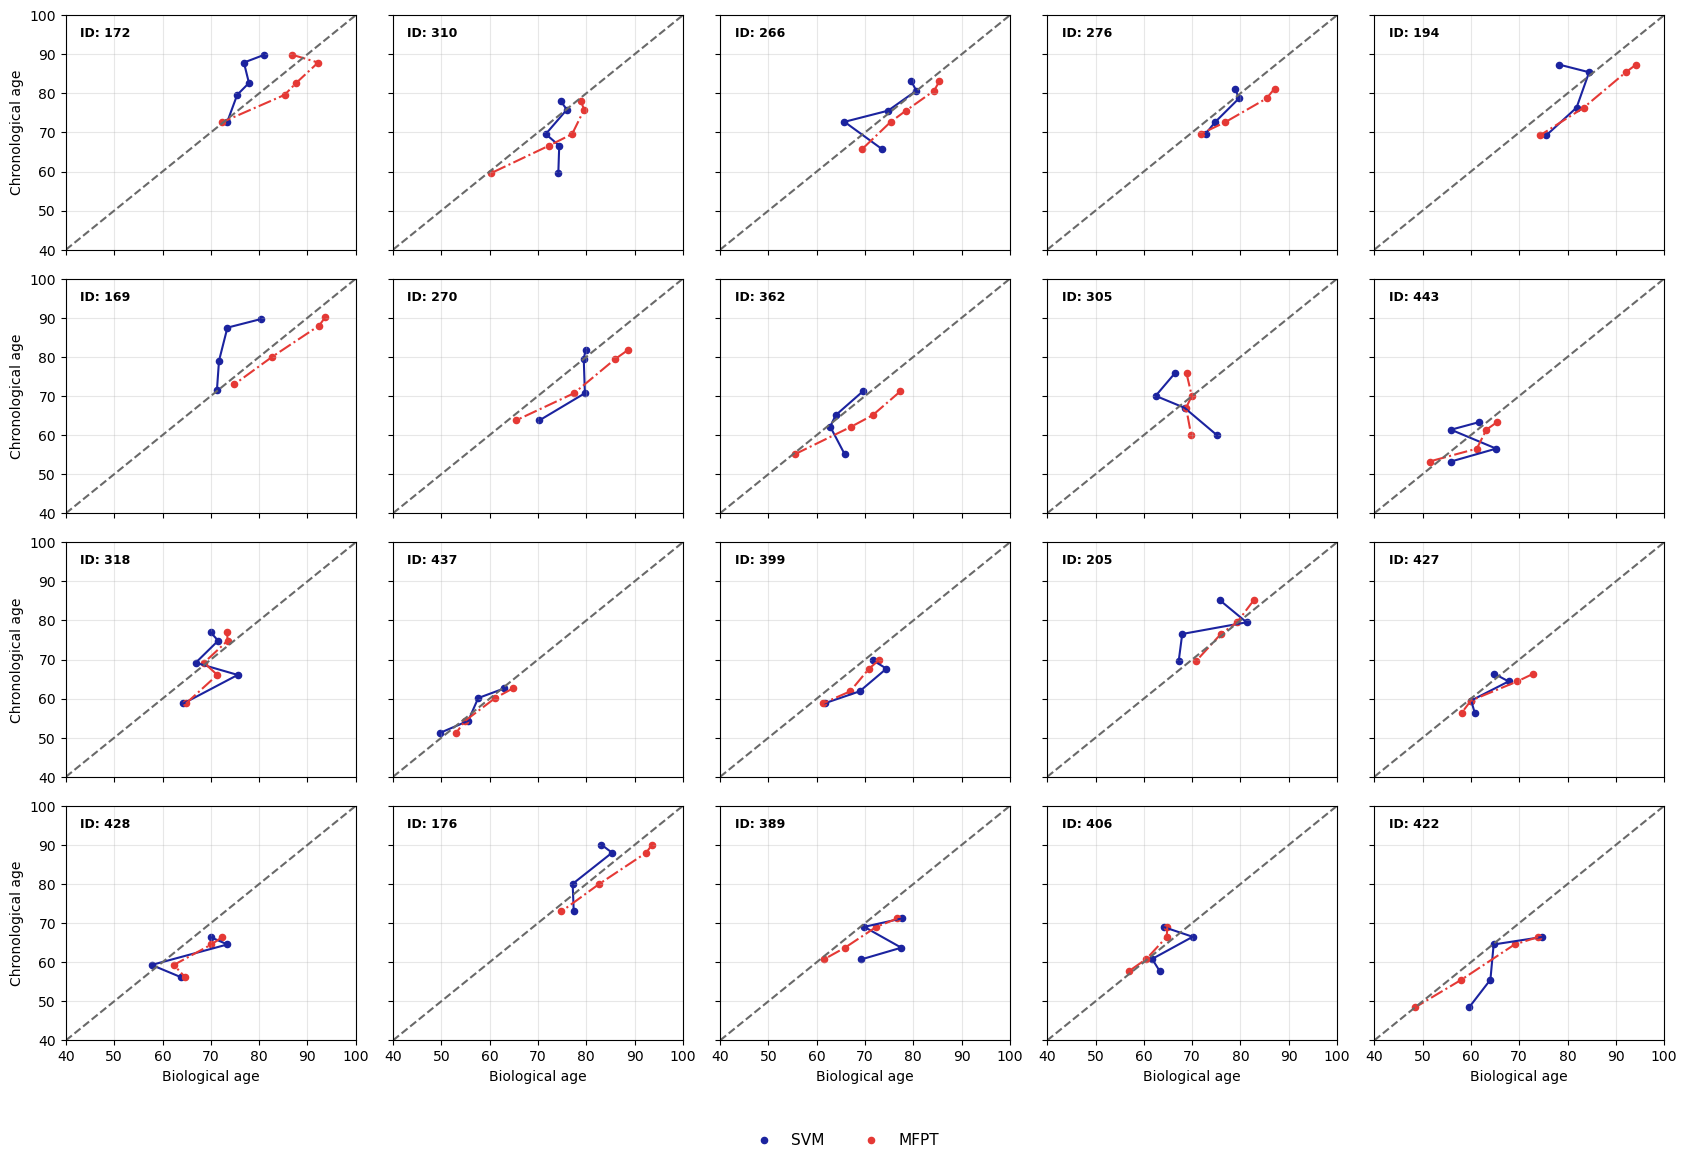

In [70]:
import math

# Your list of individuals 
individuals = [
    {"id": 172, "idx": slice(933, 938)},
    {"id": 310, "idx": slice(515, 520)},
    {"id": 266, "idx": slice(676, 681)},
    {"id": 276, "idx": slice(635, 639)},
    {"id": 194, "idx": slice(892, 896)},
    {"id": 169, "idx": slice(923, 927)},
    {"id": 270, "idx": slice(660, 664)},
    {"id": 362, "idx": slice(338, 342)},
    {"id": 305, "idx": slice(538, 542)},
    {"id": 443, "idx": slice(5, 9)},
    {"id": 318, "idx": slice(492, 497)},
    {"id": 437, "idx": slice(24, 28)},
    {"id": 399, "idx": slice(183, 187)},
    {"id": 205, "idx": slice(853, 857)},
    {"id": 427, "idx": slice(59, 63)},
    {"id": 428, "idx": slice(54, 58)},
    {"id": 176, "idx": slice(923, 927)},
    {"id": 389, "idx": slice(228, 232)},
    {"id": 406, "idx": slice(148, 152)},
    {"id": 422, "idx": slice(82, 86)},
]

# Plot settings
n_individuals = len(individuals)
n_cols = 5
n_rows = math.ceil(n_individuals / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3.5 * n_cols, 3 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

# Colors for SVM and MFPT
svm_color = "#1b239f"
mfpt_color = "#E53935"

for ax_idx, person in enumerate(individuals):
    ax = axes[ax_idx]
    
    # Sort by chronological age for SVM
    mask = test_ids == person["id"]
    y_pred = y_preds_test[mask]
    y_actual = y_actual_test[mask]
    sorted_idx = np.argsort(y_actual)
    y_pred_sorted = y_pred[sorted_idx]
    y_actual_sorted = y_actual[sorted_idx]

    # Plot SVM
    ax.scatter(y_pred_sorted, y_actual_sorted, s=20, color=svm_color, marker="o", label="SVM")
    ax.plot(y_pred_sorted, y_actual_sorted, color=svm_color, linestyle="-")

    # Plot MFPT
    ax.scatter(biological[person["idx"]], chronological[person["idx"]], s=20, color=mfpt_color, marker="o", label="MFPT")
    ax.plot(biological[person["idx"]], chronological[person["idx"]], color=mfpt_color, linestyle="-.")

    # Diagonal reference line
    ax.axline((0, 0), slope=1, linestyle='--', color='dimgrey')

    # ID label
    ax.text(0.05, 0.95, f"ID: {person['id']}", transform=ax.transAxes, ha='left', va='top', fontsize=9, weight='bold')

    ax.set_xlim(40, 100)
    ax.set_ylim(40, 100)
    ax.grid(True, alpha=0.3)

    # Axis labels
    if ax_idx // n_cols == n_rows - 1:
        ax.set_xlabel("Biological age", fontsize=10)
    if ax_idx % n_cols == 0:
        ax.set_ylabel("Chronological age", fontsize=10)

# Turn off unused subplots
for ax in axes[n_individuals:]:
    ax.axis("off")

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=11, frameon=False)

plt.tight_layout(rect=[0.03, 0.05, 1, 0.97])
#plt.show()
plt.savefig("mfpt biological vs chronological individuals.svg", format='svg', dpi=1200)

### Time to death 

A more interesting analysis would be to compute time to approximate death since this could be used to determine which individuals are on a trajectory closer to death and therefore require intervention. 

Assuming that all of them die at a certain age, you can compute time to death. It will be approximate since we don't know their death date; however, it might be accurate from the first points, where this introduced assumption is not that important 

In [9]:
filtered['Age'].max()

97.26488706

The maximum age in the dataset is 97. So, I will choose 100 as the assumed age of death and add a row containing zeros and an age of 100 for each individual 

In [10]:
# Create a new DataFrame to store the result
death = pd.DataFrame(columns=filtered.columns)

for uid in unique_ids:
    # Get all rows for this individual
    individual_rows = filtered[filtered['ID'] == uid]
    
    # Create a zero-filled row
    zero_row = pd.DataFrame([[0]*len(filtered.columns)], columns=filtered.columns)
    zero_row.at[0, 'ID'] = uid
    zero_row.at[0, 'Age'] = 100  

    # Concatenate individual's data followed by the zero_row
    combined = pd.concat([individual_rows, zero_row], ignore_index=True)

    # Append to result DataFrame
    death = pd.concat([death, combined], ignore_index=True)


death.head(10)

ID         Age  cg16867657  cg22454769  cg07082267  cg10917602  cg23744638  \
0  4   66.530134    0.646309    0.486484    0.380866    0.583188    0.569642   
1  4   73.568486    0.799299    0.495504    0.357534    0.543829    0.527590   
2  4   82.403833    0.737156    0.547054    0.414491    0.577654    0.553128   
3  4   84.528405    0.837627    0.559392    0.355323    0.525814    0.521606   
4  4  100.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
5  5   66.530134    0.702288    0.526904    0.361381    0.543922    0.672069   
6  5   73.852509    0.820860    0.577691    0.373576    0.498148    0.614670   
7  5   82.403833    0.838836    0.572076    0.304438    0.486565    0.655282   
8  5   84.531143    0.840359    0.596924    0.263943    0.493135    0.623089   
9  5  100.000000    0.000000    0.000000    0.000000    0.000000    0.000000   

   cg26153045  cg02085953  cg07927379  ...  cg00292135  cg11693709  \
0    0.375602    0.354024    0.042392  ...    0.114310    0.417675   
1    0.311308    0.308736    0.043762  ...    0.107074    0.411936   
2    0.342647    0.267324    0.160710  ...    0.150684    0.392358   
3    0.253690    0.271183    0.079572  ...    0.089873    0.393527   
4    0.000000    0.000000    0.000000  ...    0.000000    0.000000   
5    0.348870    0.322995    0.105713  ...    0.141782    0.382297   
6    0.316506    0.343476    0.077343  ...    0.178324    0.347342   
7    0.244592    0.348290    0.133586  ...    0.159521    0.314774   
8    0.301661    0.289652    0.175717  ...    0.189232    0.281201   
9    0.000000    0.000000    0.000000  ...    0.000000    0.000000   

   cg23737927  cg16624521  cg25994988  cg06761850  cg02315732  cg20732076  \
0    0.759947    0.681296    0.474299    0.296988    0.560873    0.190937   
1    0.833769    0.659152    0.384782    0.281054    0.561824    0.155627   
2    0.639692    0.683428    0.451075    0.311980    0.428577    0.153598   
3    0.699139    0.644453    0.331450    0.325187    0.373445    0.112596   
4    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
5    0.741858    0.559220    0.405146    0.290188    0.452989    0.120012   
6    0.727501    0.505839    0.344634    0.308590    0.524471    0.104955   
7    0.627057    0.513647    0.366603    0.238929    0.452037    0.105946   
8    0.625621    0.495396    0.306589    0.238906    0.361037    0.113026   
9    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   

   cg04608933  cg11436767  
0    0.675305    0.406668  
1    0.655442    0.400266  
2    0.706284    0.374923  
3    0.678522    0.353805  
4    0.000000    0.000000  
5    0.625062    0.417433  
6    0.599907    0.342823  
7    0.573729    0.392948  
8    0.575963    0.334129  
9    0.000000    0.000000  

[10 rows x 52 columns]

In [11]:
xtraj = death.iloc[:, 2:].to_numpy()
xtraj = xtraj.astype(np.float32)
print(xtraj)

[[0.6463094  0.48648372 0.38086602 ... 0.19093734 0.6753051  0.40666825]
 [0.7992989  0.49550393 0.3575344  ... 0.15562695 0.65544224 0.4002661 ]
 [0.7371562  0.54705423 0.41449058 ... 0.15359783 0.7062843  0.37492344]
 ...
 [0.6564735  0.53342724 0.32542562 ... 0.10561421 0.6592708  0.43372092]
 [0.73187643 0.5062885  0.35437346 ... 0.10092261 0.70163155 0.40843266]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [12]:
ptrajne = death.iloc[:, 0].to_numpy()
ptrajne = ptrajne.astype(np.float32)
print(ptrajne)

[  4.   4.   4. ... 444. 444. 444.]


In [13]:
ttrajne = death.iloc[:, 1].to_numpy()
ttrajne = ttrajne.astype(np.float32)
print(ttrajne)

[ 66.530136  73.56849   82.40383  ...  61.03491   63.279945 100.      ]


In [14]:
age = death.iloc[:, 1].to_numpy()
age = age.astype(np.float32)
age

array([ 66.530136,  73.56849 ,  82.40383 , ...,  61.03491 ,  63.279945,
       100.      ], shape=(1201,), dtype=float32)

In [15]:
IndA = age>99

Parameters: 
- Gamma=0
- Envelope_scale=0.01
- ny=6

These are the default parameters

2025-08-16 12:14:01.544481: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1755342841.545611  906615 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7996 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


iteration 0, loss=-441.797, delta_r=37.0983, |dx|=0.748129, time=1.5593
iteration 1000, loss=-420.809, delta_r=51.6349, |dx|=0.176324, time=2.91743
iteration 2000, loss=-420.945, delta_r=52.0767, |dx|=0.0176848, time=4.25289
iteration 3000, loss=-420.982, delta_r=52.0198, |dx|=0.00814561, time=5.59742
iteration 4000, loss=-420.976, delta_r=51.943, |dx|=0.003706, time=6.94147
iteration 5000, loss=-421.043, delta_r=51.9517, |dx|=0.00188425, time=8.2818
iteration 6000, loss=-421.074, delta_r=51.9635, |dx|=0.00113276, time=9.63802
iteration 7000, loss=-421.068, delta_r=51.9628, |dx|=0.000822278, time=10.9761
iteration 8000, loss=-421.094, delta_r=51.963, |dx|=0.000547656, time=12.332
iteration 9000, loss=-421.098, delta_r=51.9781, |dx|=0.000315507, time=13.6935
iteration 10000, loss=-421.103, delta_r=51.972, |dx|=0.000247695, time=15.0486
iteration 11000, loss=-421.107, delta_r=51.9791, |dx|=0.000155007, time=16.4182
iteration 12000, loss=-421.111, delta_r=51.9756, |dx|=0.000112534, time=1

/localhome/home/fbsskr/Notebooks/Students/Ella/Methylation/OptimalRCs.py:2080: RuntimeWarning: divide by zero encountered in log
  if lnzmfpt: ly = -np.log(ly)
/localhome/home/fbsskr/Notebooks/Students/Ella/Methylation/OptimalRCs.py:2080: RuntimeWarning: invalid value encountered in log
  if lnzmfpt: ly = -np.log(ly)


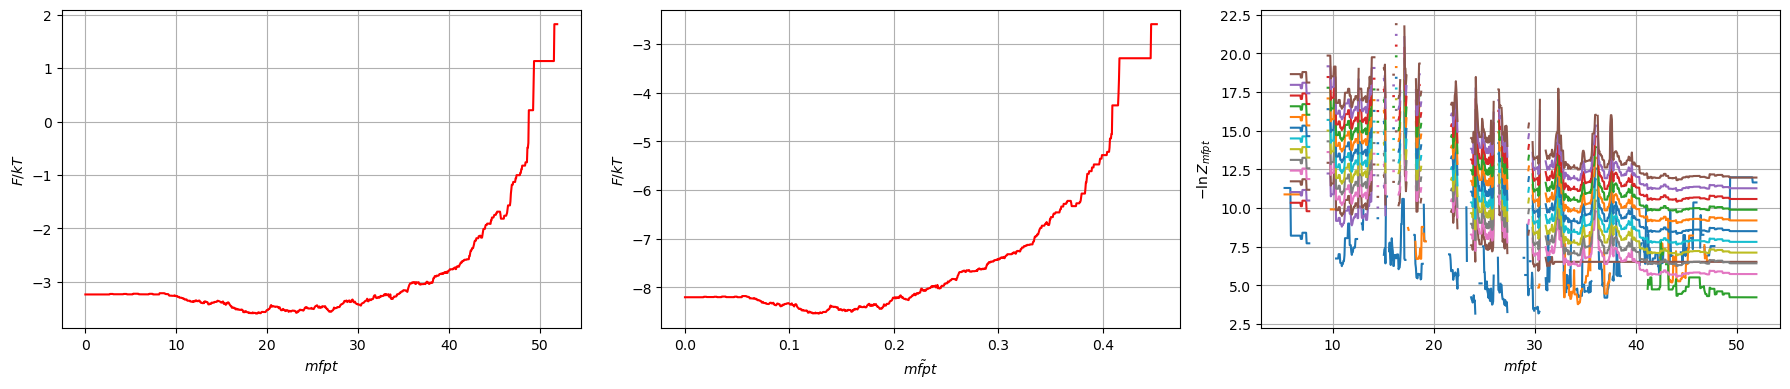

In [16]:
OptimalRCs.envelope_scale=0.01

def comp_y():
    return xtraj[:,np.random.randint(xtraj.shape[1])]

q=OptimalRCs.MFPTNE(IndA=IndA, i_traj=ptrajne, t_traj=ttrajne)
np.random.seed(0)
q.fit_transform(comp_y,dxmin=1e-4)
q.plots(dt_sim=0.0005)  
plt.savefig("to death plots with default hyperparameters.svg", format='svg', dpi=1200) 

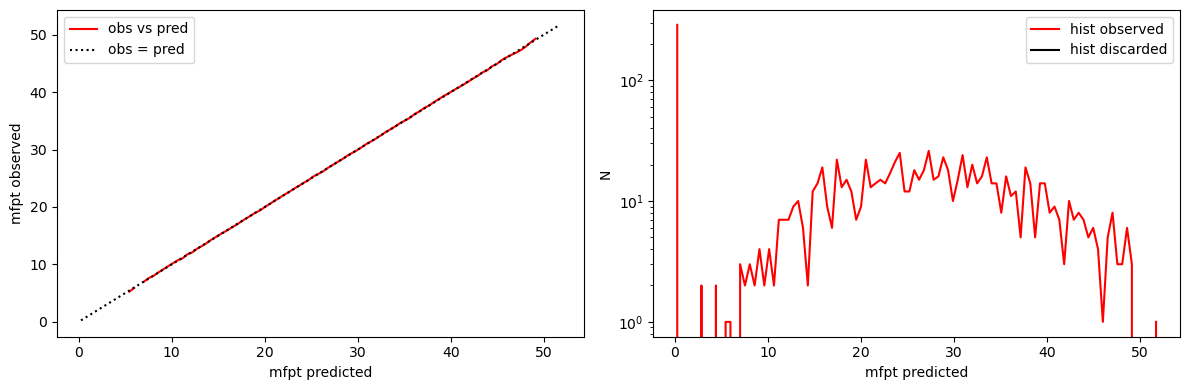

In [313]:
q.plot_obs_pred()
plt.savefig("to death obs_pred plots with default hyperparameters.svg", format='svg', dpi=1200) 

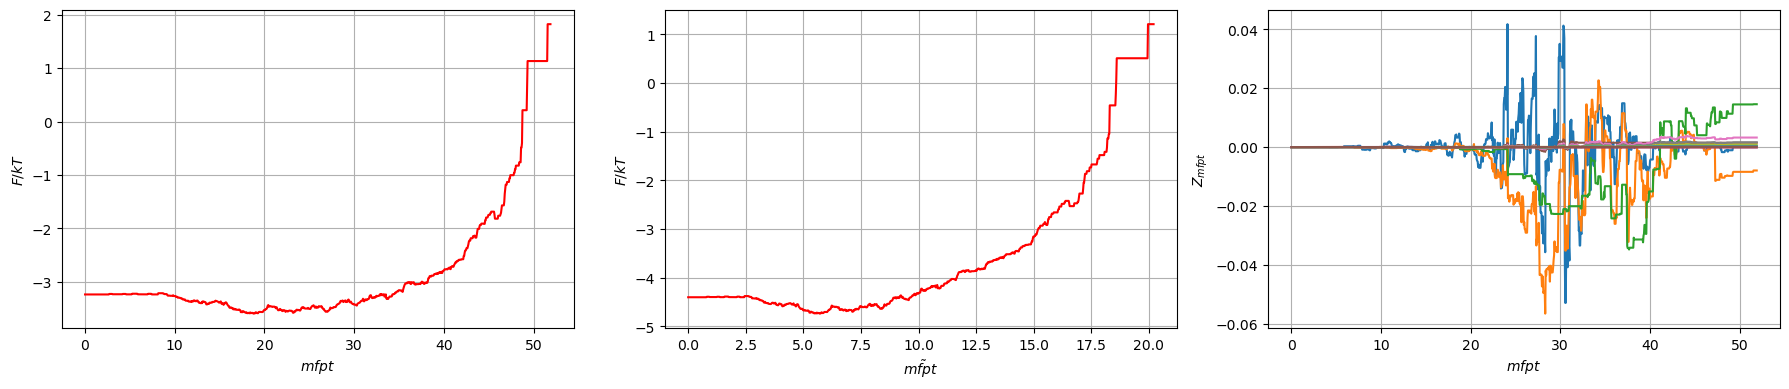

In [314]:
q.plots(lnzmfpt=False)
plt.savefig("to death plots lnzmfpt=False with default hyperparameters.svg", format='svg', dpi=1200) 

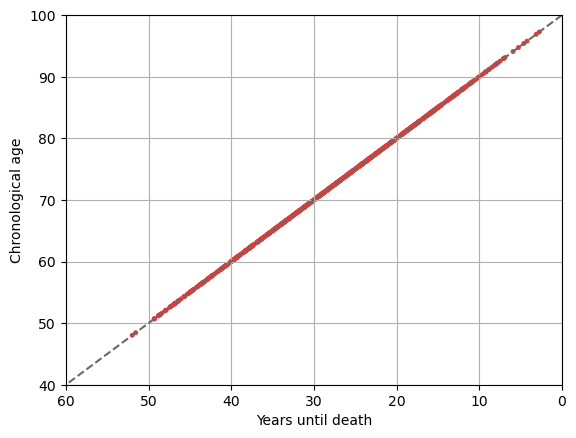

In [371]:
t = q.r
v = ttrajne

# Mask to keep only points that are not (0, 100)
mask = ~((t == 0) & (v == 100))

# Apply mask
t_filtered = t[mask]
v_filtered = v[mask]

plt.scatter(t_filtered, v_filtered, edgecolor="none",
        s=50, color="#E53935", marker=".")

plt.xlabel("Years until death")
plt.ylabel("Chronological age")
plt.axline((50, 50), slope=-1, linestyle= '--', color='dimgrey')
plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
plt.xlim(60, 0)
plt.ylim(40, 100)
plt.grid(True)
# plt.show()
plt.savefig("mfpt years to 100 vs years to death with default hyperparameters.svg", format='svg', dpi=1200) 

Again, there is almost perfect agreement between biological and chronological, indicating overfitting. Therefore, again, I can adjust the envelope scale, ny and gamma

Parameters: 
- Gamma=0
- Envelope_scale=0.01
- ny=6, 5, 4

Here, I tried different values of ny 

iteration 0, loss=-442.125, delta_r=41.6315, |dx|=0.668842, time=0.00523806
iteration 1000, loss=-425.301, delta_r=53.1326, |dx|=0.152669, time=1.58234
iteration 2000, loss=-424.968, delta_r=54.4655, |dx|=0.0256237, time=3.15717
iteration 3000, loss=-423.252, delta_r=53.3533, |dx|=0.0195915, time=4.71968
iteration 4000, loss=-423.444, delta_r=52.7136, |dx|=0.0159428, time=6.29304
iteration 5000, loss=-423.362, delta_r=53.8717, |dx|=0.0121108, time=7.87261
iteration 6000, loss=-423.305, delta_r=54.1407, |dx|=0.0119374, time=9.46721
iteration 7000, loss=-423.622, delta_r=54.2867, |dx|=0.00968815, time=11.017
iteration 8000, loss=-423.025, delta_r=54.6662, |dx|=0.0101729, time=12.5669
iteration 9000, loss=-422.537, delta_r=55.3025, |dx|=0.0089261, time=14.121
iteration 10000, loss=-422.73, delta_r=55.8164, |dx|=0.00742037, time=15.6744
iteration 11000, loss=-422.651, delta_r=55.4646, |dx|=0.00631739, time=17.2233
iteration 12000, loss=-422.409, delta_r=54.8444, |dx|=0.0058372, time=18.771

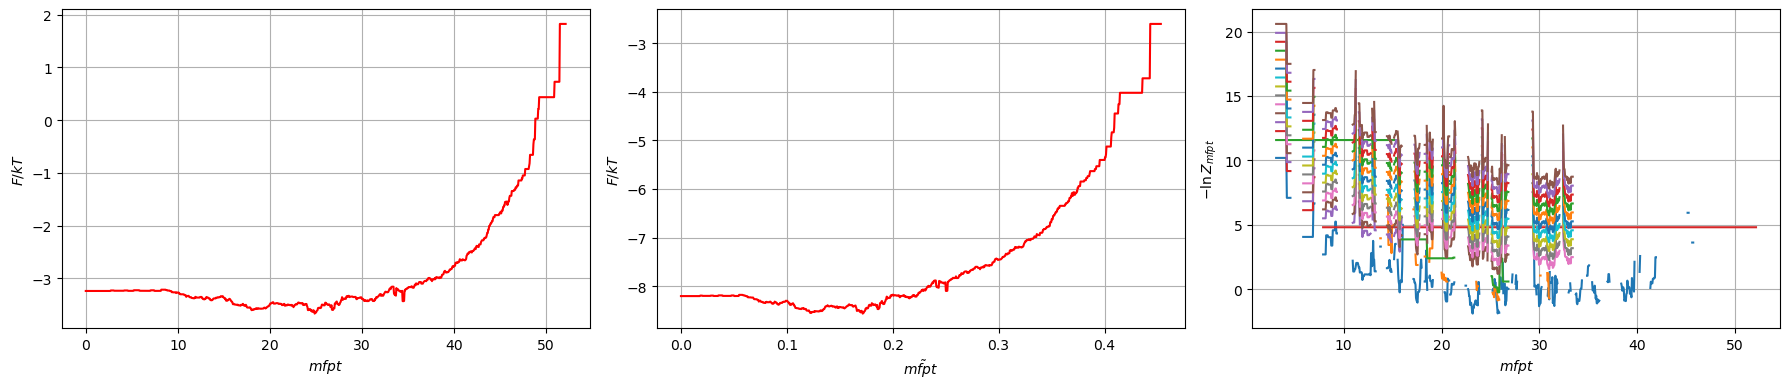

In [316]:
q=OptimalRCs.MFPTNE(IndA=IndA, i_traj=ptrajne, t_traj=ttrajne)
np.random.seed(0)
q.fit_transform(comp_y,dxmin=1e-4, ny=2) 
q.plots(dt_sim=0.0005) 

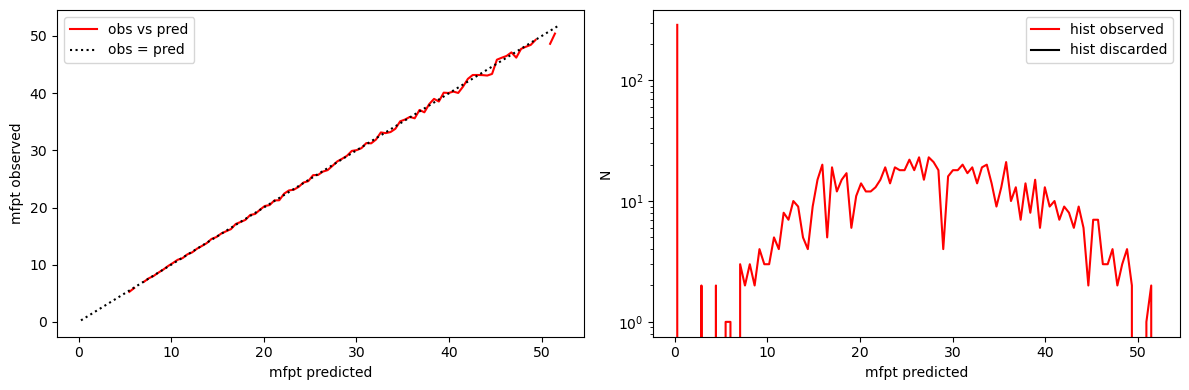

In [317]:
q.plot_obs_pred()

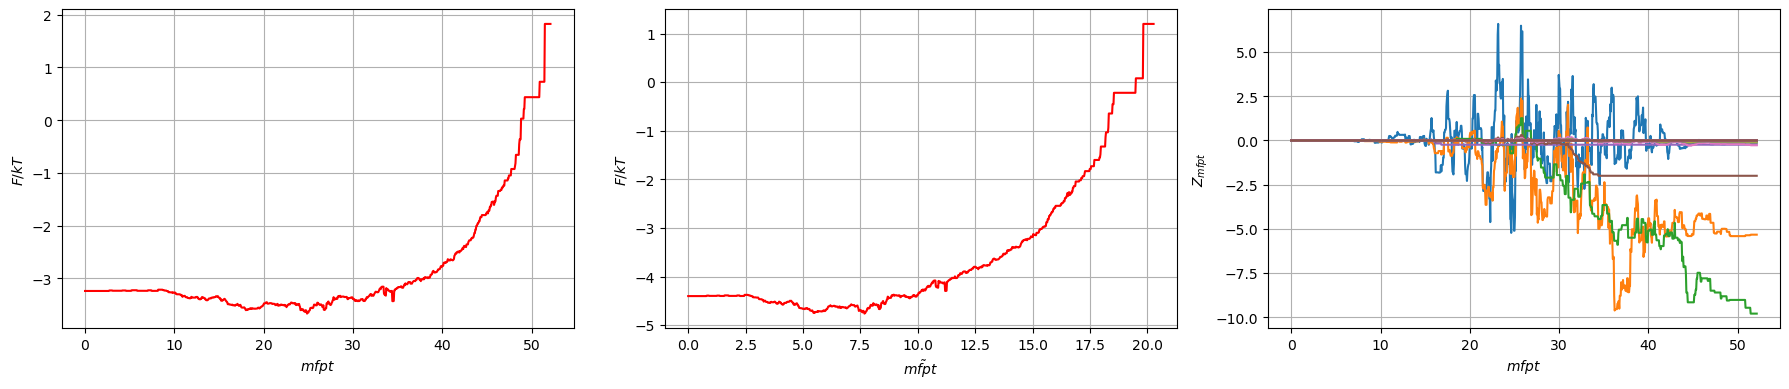

In [318]:
q.plots(lnzmfpt=False)

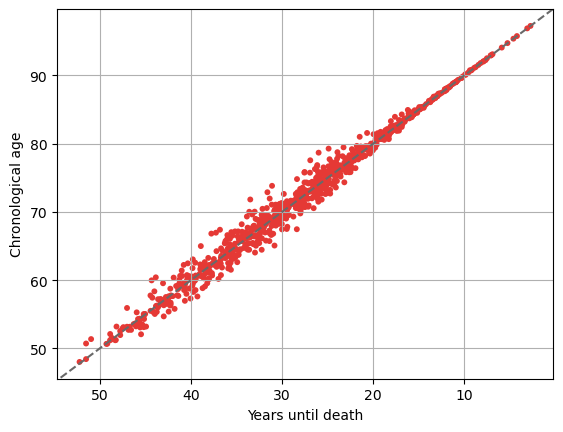

In [319]:
t = q.r
v = ttrajne

# Mask to keep only points that are not (0, 100)
mask = ~((t == 0) & (v == 100))

# Apply mask
t_filtered = t[mask]
v_filtered = v[mask]

plt.scatter(t_filtered, v_filtered, edgecolor="none",
        s=18, color="#E53935")

plt.xlabel("Years until death")
plt.ylabel("Chronological age")
plt.axline((50, 50), slope=-1, linestyle= '--', color='dimgrey')
plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

Parameters:
- envelope_scale=1000000
- ny=6
- gamma=0

iteration 0, loss=-441.797, delta_r=37.0983, |dx|=0.748129, time=0.00488114
iteration 1000, loss=-422.993, delta_r=53.9013, |dx|=0.163194, time=1.28328
iteration 2000, loss=-423.26, delta_r=53.7938, |dx|=0.0174807, time=2.55328
iteration 3000, loss=-423.389, delta_r=52.5462, |dx|=0.00852829, time=3.82615
iteration 4000, loss=-423.333, delta_r=51.7732, |dx|=0.00705295, time=5.09556
iteration 5000, loss=-423.072, delta_r=51.536, |dx|=0.00562333, time=6.35507
iteration 6000, loss=-422.92, delta_r=51.4275, |dx|=0.0046176, time=7.61963
iteration 7000, loss=-422.792, delta_r=51.6383, |dx|=0.00374499, time=8.91884
iteration 8000, loss=-422.62, delta_r=51.5998, |dx|=0.00338755, time=10.2003
iteration 9000, loss=-422.448, delta_r=51.7574, |dx|=0.00278592, time=11.4907
iteration 10000, loss=-422.374, delta_r=51.9152, |dx|=0.0025002, time=12.7692
iteration 11000, loss=-422.278, delta_r=52.1267, |dx|=0.0022398, time=14.0525
iteration 12000, loss=-422.104, delta_r=52.009, |dx|=0.00201039, time=15.3

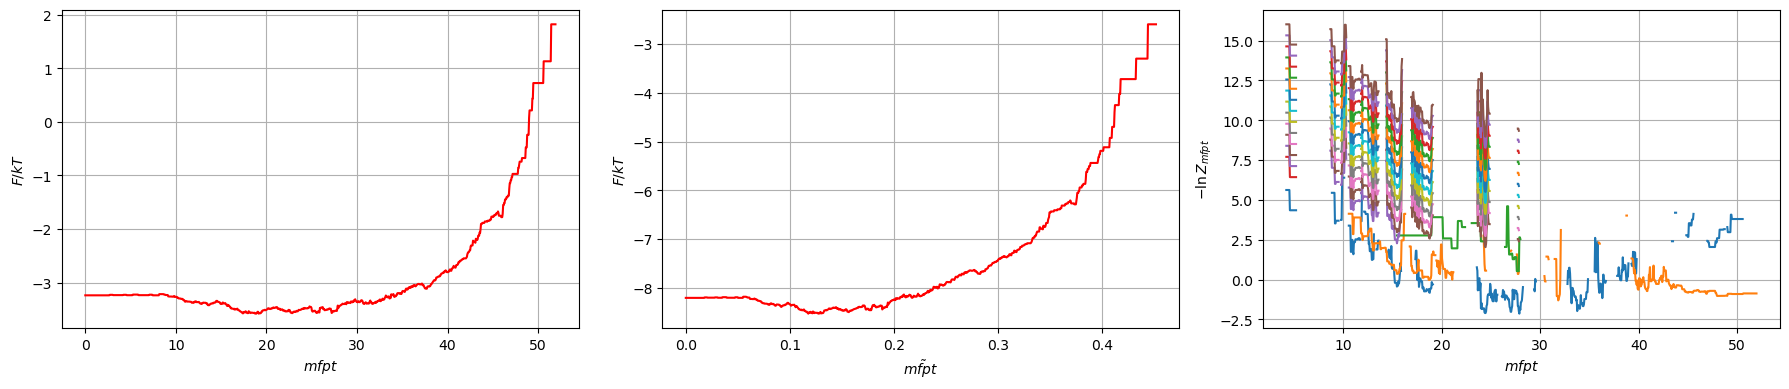

In [320]:
OptimalRCs.envelope_scale=1000000

q=OptimalRCs.MFPTNE(IndA=IndA, i_traj=ptrajne, t_traj=ttrajne)
np.random.seed(0)
q.fit_transform(comp_y,dxmin=1e-4, ny=6, gamma=0)
q.plots(dt_sim=0.0005) 

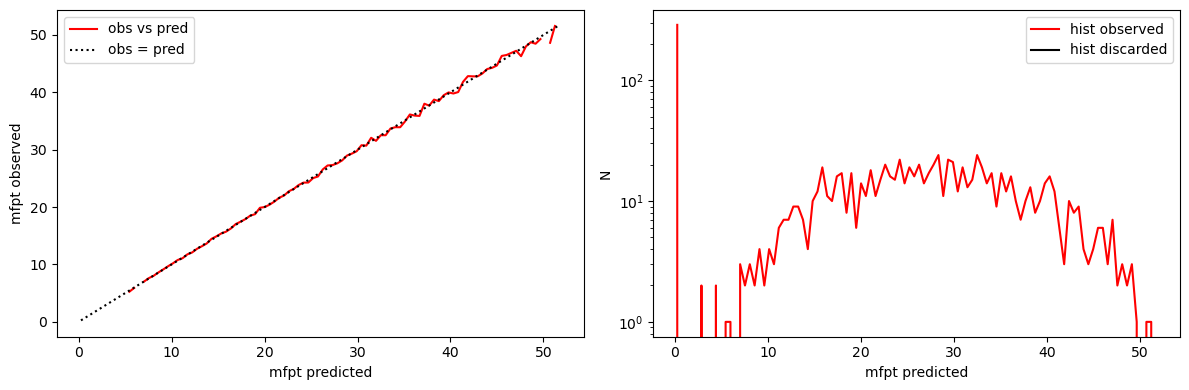

In [321]:
q.plot_obs_pred()

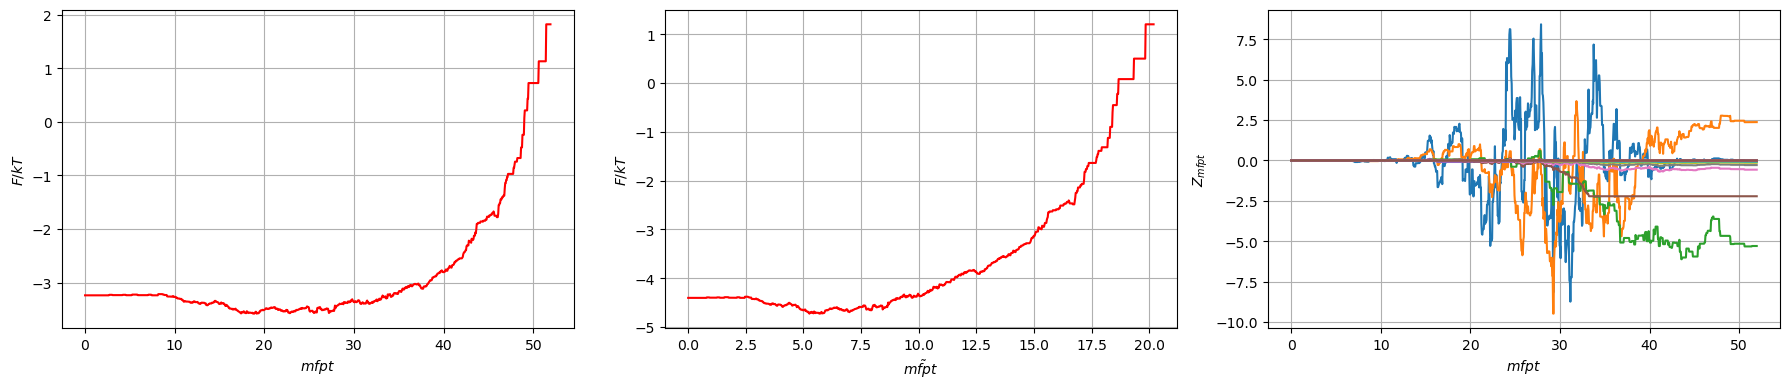

In [322]:
q.plots(lnzmfpt=False)

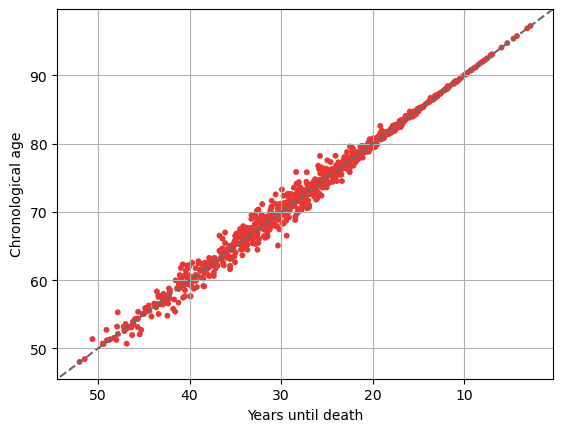

In [323]:
t = q.r
v = ttrajne

# Mask to keep only points that are not (0, 100)
mask = ~((t == 0) & (v == 100))

# Apply mask
t_filtered = t[mask]
v_filtered = v[mask]

plt.scatter(t_filtered, v_filtered, edgecolor="none",
        s=18, color="#E53935")

plt.xlabel("Years until death")
plt.ylabel("Chronological age")
plt.axline((50, 50), slope=-1, linestyle= '--', color='dimgrey')
plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

Parameters:
- envelope_scale=0.01
- ny=6
- gamma=0.1

iteration 0, loss=-419.896, delta_r=40.4251, |dx|=0.61058, time=0.150906
iteration 1000, loss=-427.998, delta_r=50.3444, |dx|=0.13282, time=1.51545
iteration 2000, loss=-427.115, delta_r=50.4572, |dx|=0.0181749, time=2.87042
iteration 3000, loss=-426.97, delta_r=50.2552, |dx|=0.0091411, time=4.22871
iteration 4000, loss=-426.538, delta_r=50.6042, |dx|=0.00709338, time=5.58345
iteration 5000, loss=-426.441, delta_r=50.4595, |dx|=0.00555519, time=6.94774
iteration 6000, loss=-426.174, delta_r=50.9179, |dx|=0.00487667, time=8.32543
iteration 7000, loss=-426.217, delta_r=51.4218, |dx|=0.00381063, time=9.68208
iteration 8000, loss=-426.381, delta_r=51.6762, |dx|=0.00349233, time=11.0587
iteration 9000, loss=-426.21, delta_r=52.4463, |dx|=0.00301693, time=12.4523
iteration 10000, loss=-426.24, delta_r=52.4879, |dx|=0.00269275, time=13.8273
iteration 11000, loss=-426.175, delta_r=52.7273, |dx|=0.00263348, time=15.1962
iteration 12000, loss=-425.936, delta_r=52.7508, |dx|=0.00255507, time=16.5

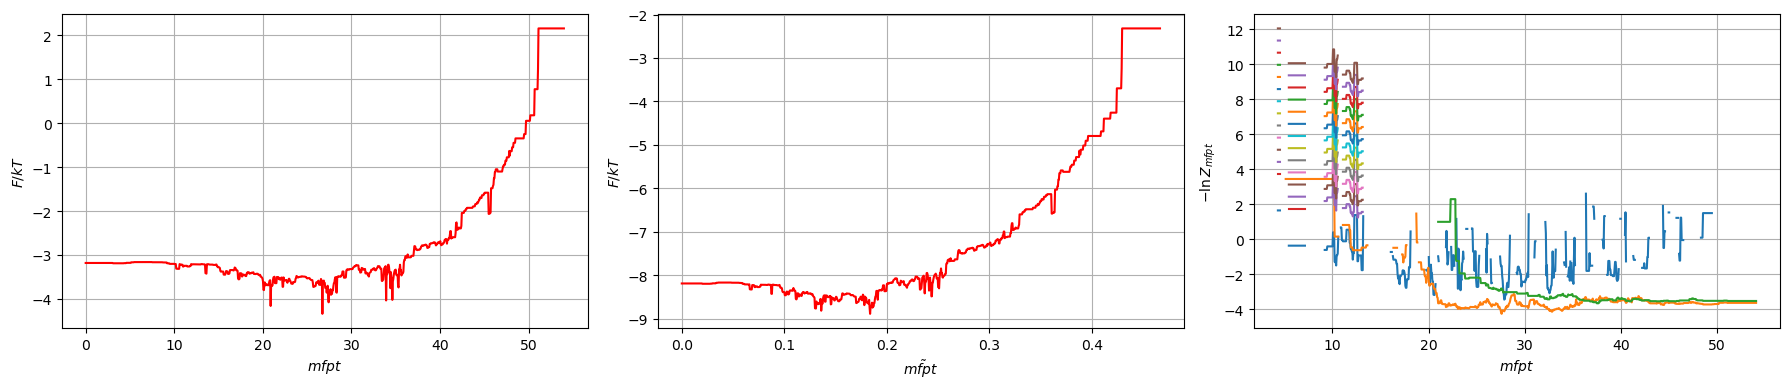

In [17]:
OptimalRCs.envelope_scale=0.01

q=OptimalRCs.MFPTNE(IndA=IndA, i_traj=ptrajne, t_traj=ttrajne)
np.random.seed(0)
q.fit_transform(comp_y,dxmin=1e-4, ny=6, gamma=0.1)
q.plots(dt_sim=0.0005) 
plt.savefig("to death plots with tuned hyperparameters.svg", format='svg', dpi=1200)

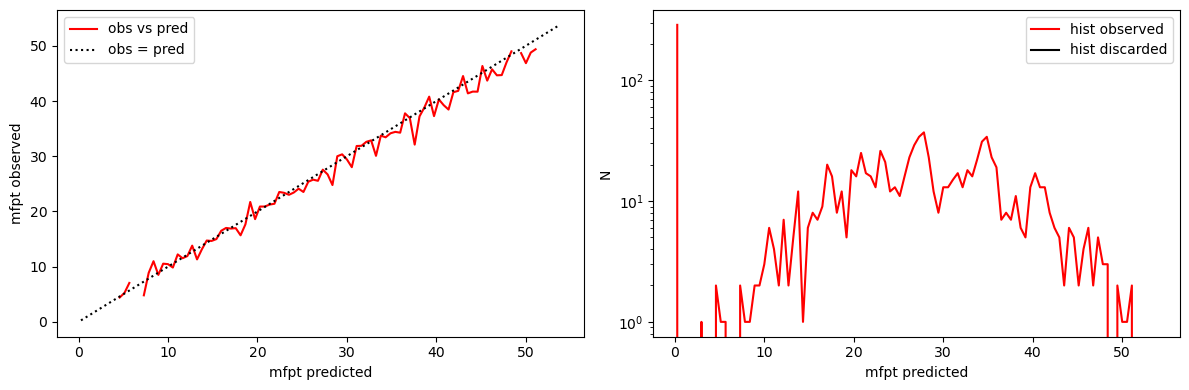

In [325]:
q.plot_obs_pred()
plt.savefig("to death obs_pred plots with tuned hyperparameters.svg", format='svg', dpi=1200)

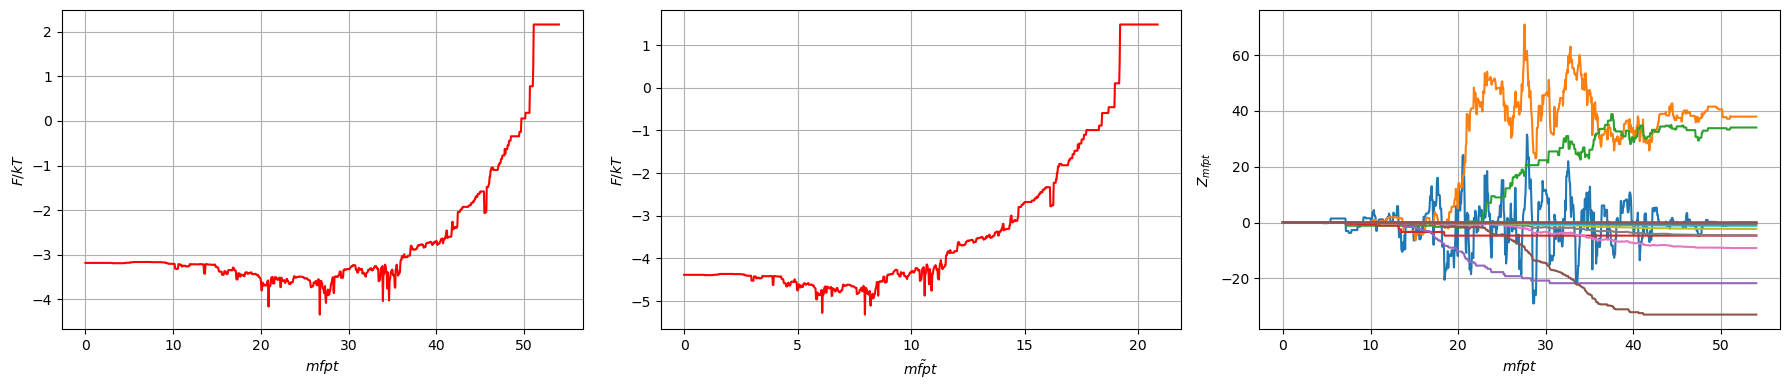

In [326]:
q.plots(lnzmfpt=False)
plt.savefig("to death plots lnzmfpt=False with tuned hyperparameters.svg", format='svg', dpi=1200)

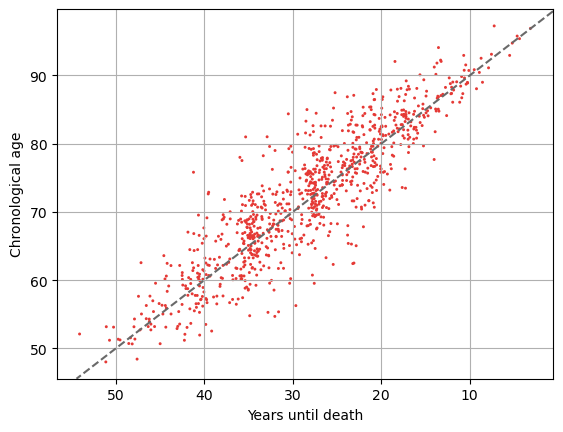

In [18]:
biol = q.r
chron = ttrajne

# Mask to keep only points that are NOT (0, 100)
mask = ~((biol == 0) & (chron == 100))

# Apply mask
biol_filtered = biol[mask]
chron_filtered = chron[mask]

plt.scatter(biol_filtered, chron_filtered, edgecolor="none",
        s=18, color="#E53935", marker=".")

plt.xlabel("Years until death")
plt.ylabel("Chronological age")
plt.axline((50, 50), slope=-1, linestyle= '--', color='dimgrey')
plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
plt.grid(True)
# plt.show()
plt.savefig("mfpt years to 100 vs years to death with tuned hyperparameters.svg", format='svg', dpi=1200) 

In [36]:
print("Performance")
print("Pearson r:", pearsonr(np.array(chron_filtered), np.array(biol_filtered))[0])

Performance
Pearson r: -0.8896817862081577


Here is a plot of time to death using MFPT versus chronological age for one individual showing their trajectory.

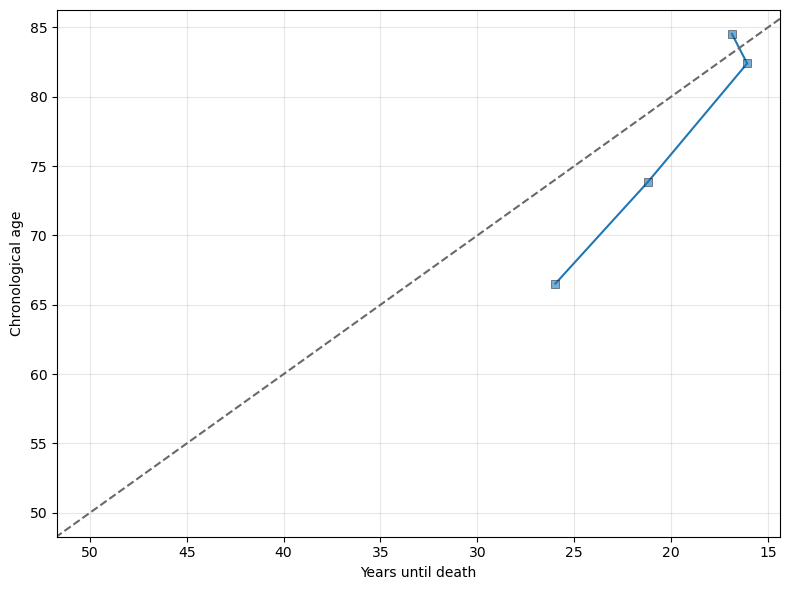

In [328]:
target_id = 5

# Filter rows for that ID
mask = ptrajne == target_id
subset_biol = biol[mask][:-1]   # remove last point
subset_chron = chron[mask][:-1] # remove last point

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    subset_biol, subset_chron,
    s=28, marker='s', alpha=0.6, zorder=10,
    edgecolor="black", linewidth=0.5
)
plt.plot(subset_biol, subset_chron,)

plt.xlabel("Years until death")
plt.ylabel("Chronological age")
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
plt.axline((50, 50), slope=-1, linestyle= '--', color='dimgrey')
plt.tight_layout()
plt.show()


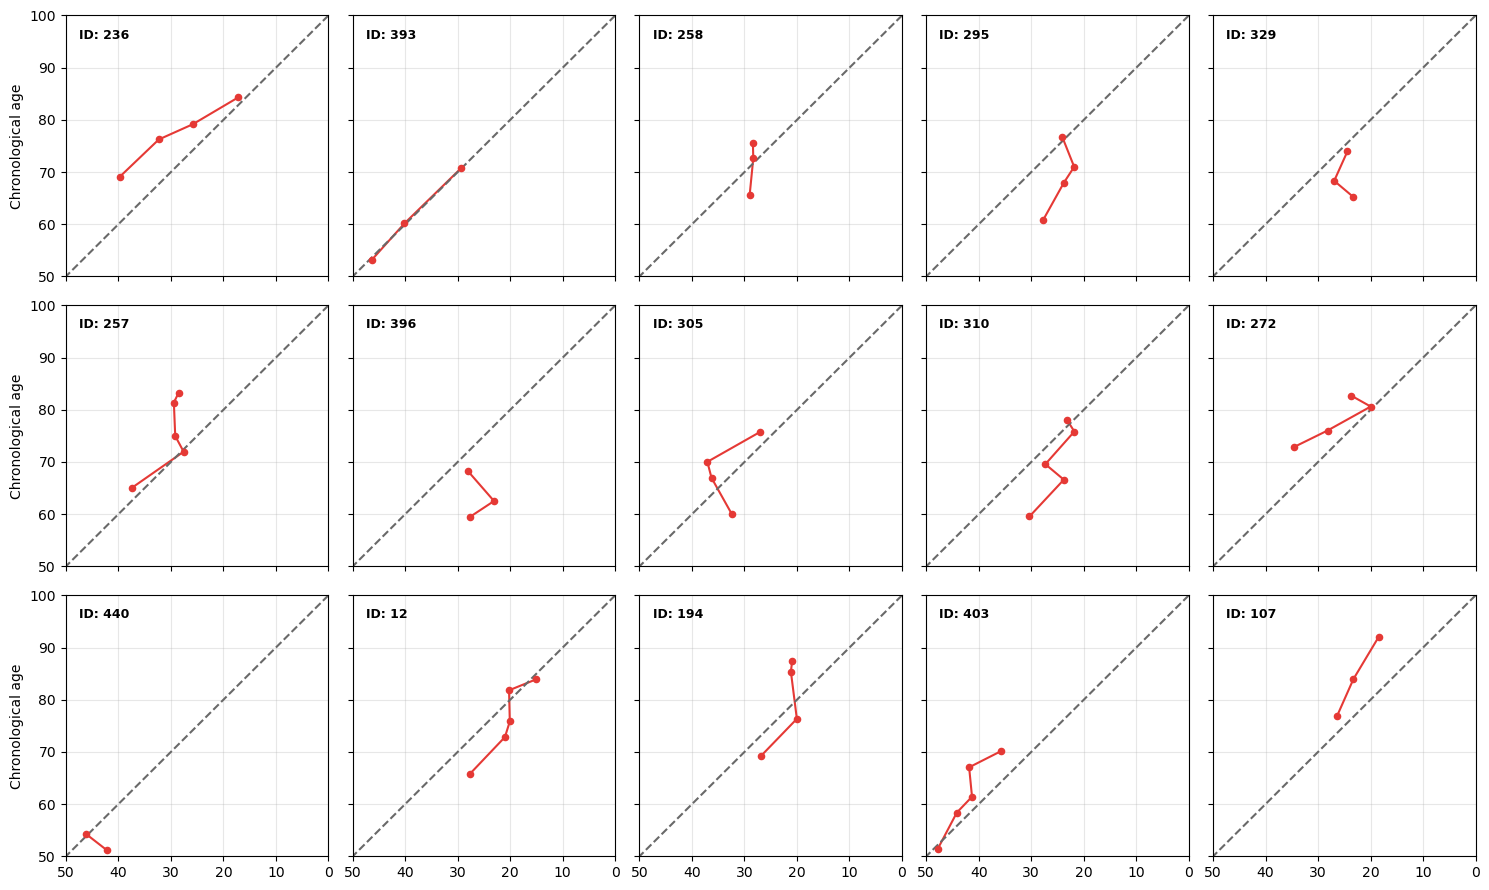

In [329]:
# List of IDs
ID_list = np.array([236, 393, 258, 295, 329, 
                    257, 396, 305, 310, 272, 
                    440, 12, 194, 403, 107])

# Set up subplots (e.g., 4x5 grid)
fig, axes = plt.subplots(3, 5, figsize=(15, 9), sharex=True, sharey=True)
axes = axes.flatten()

nrows, ncols = 4, 5

for idx, (ax, target_id) in enumerate(zip(axes, ID_list)):
    # Filter rows for that ID
    mask = ptrajne == target_id
    subset_biol = biol[mask][:-1]   # remove last point
    subset_chron = chron[mask][:-1] # remove last point

    # Scatter + line
    ax.scatter(
        subset_biol, subset_chron,
        s=20, color="#E53935", marker='o', zorder=10
    )
    ax.plot(subset_biol, subset_chron, color="#E53935")


    # Add ID text
    ax.text(
        0.05, 0.95, f"ID: {str(target_id)}", transform=ax.transAxes,
        ha='left', va='top', fontsize=9, weight='bold'
    )
    
    ax.grid(True, alpha=0.3)
    ax.invert_xaxis()
    ax.set_xlim(50, 0)
    #ax.invert_yaxis()
    ax.set_ylim(50, 100)

    ax.axline((50, 50), slope=-1, linestyle= '--', color='dimgrey')

    # Only label leftmost column
    if idx % ncols == 0:
        ax.set_ylabel("Chronological age", fontsize=10)

    # Only label bottom row
    if idx // ncols == nrows - 1:
        ax.set_xlabel("Years until death", fontsize=10)

plt.tight_layout()
#plt.show()
plt.savefig("mfpt time to death vs chronological individuals.svg", format='svg', dpi=1200)

**Time to death for older individuals potentially closer to death**

In [23]:
(filtered['Age'] > 92).sum()

np.int64(13)

There are 13 samples where the individual older than 92. I want to try time to death for only these individuals. To do this I will set an approximate death of age 100 for only these individuals. 

In [24]:
# Create a new DataFrame to store the result
close_to_death = pd.DataFrame(columns=filtered.columns)

for uid in unique_ids:
    # Get all rows for this individual
    individual_rows = filtered[filtered['ID'] == uid]
    
    # Only proceed if the sample has an age > 92
    if (individual_rows['Age'] > 92).any():
        # Create a zero-filled row
        zero_row = pd.DataFrame([[0]*len(filtered.columns)], columns=filtered.columns)
        zero_row.at[0, 'ID'] = uid
        zero_row.at[0, 'Age'] = 100 

        # Concatenate individual's data followed by the zero_row
        combined = pd.concat([individual_rows, zero_row], ignore_index=True)

        # Append to result DataFrame
        close_to_death = pd.concat([close_to_death, combined], ignore_index=True)
    else:
        # If not > 92, just keep the individual's rows as-is
        close_to_death = pd.concat([close_to_death, individual_rows], ignore_index=True)

close_to_death.iloc[100:150,:]

ID         Age  cg16867657  cg22454769  cg07082267  cg10917602  \
100   97   86.669405    0.873695    0.579487    0.316486    0.521077   
101  101   77.478085    0.788059    0.564477    0.316317    0.597027   
102  101   84.439733    0.862520    0.667797    0.361490    0.551271   
103  102   91.822040    0.777825    0.726893    0.385588    0.720573   
104  102   94.091718    0.778600    0.735257    0.360285    0.621855   
105  102  100.000000    0.000000    0.000000    0.000000    0.000000   
106  103   77.535613    0.641722    0.607560    0.383253    0.684761   
107  103   84.379904    0.627125    0.602568    0.311349    0.657766   
108  103   87.378508    0.691384    0.712361    0.335130    0.660356   
109  104   82.460497    0.689664    0.735978    0.338990    0.542825   
110  104   92.065708    0.750571    0.708904    0.308156    0.506731   
111  104  100.000000    0.000000    0.000000    0.000000    0.000000   
112  105   75.416667    0.678207    0.659439    0.333869    0.585825   
113  105   82.543831    0.695475    0.704470    0.304504    0.485466   
114  107   76.818486    0.703924    0.479402    0.276333    0.438730   
115  107   83.945360    0.789848    0.685665    0.305365    0.467056   
116  107   92.057495    0.723388    0.632203    0.306163    0.465051   
117  107  100.000000    0.000000    0.000000    0.000000    0.000000   
118  108   76.724195    0.780508    0.611658    0.319384    0.487028   
119  108   86.702259    0.786479    0.719202    0.262064    0.452327   
120  110   83.233563    0.686524    0.521629    0.354440    0.488537   
121  110   91.548255    0.764938    0.718080    0.296275    0.456937   
122  116   82.155709    0.636614    0.585258    0.328381    0.504617   
123  116   85.136208    0.735274    0.789015    0.303864    0.528683   
124  116   90.735113    0.803201    0.648925    0.266246    0.487722   
125  119   74.091552    0.708512    0.619512    0.359590    0.577711   
126  119   81.169406    0.701206    0.698707    0.326754    0.518694   
127  119   84.112252    0.627590    0.567418    0.318003    0.498983   
128  119   90.171116    0.815430    0.762337    0.266790    0.469896   
129  119   92.528405    0.800277    0.731823    0.274899    0.386203   
130  119  100.000000    0.000000    0.000000    0.000000    0.000000   
131  121   76.305939    0.628561    0.575378    0.312433    0.448996   
132  121   83.211648    0.724731    0.560325    0.249043    0.475982   
133  125   74.034024    0.714912    0.514651    0.341748    0.533022   
134  125   81.169406    0.639628    0.447363    0.321024    0.456478   
135  126   75.847030    0.759664    0.775563    0.310463    0.673747   
136  126   82.800460    0.651685    0.777766    0.372533    0.696710   
137  128   74.674885    0.848897    0.523952    0.235195    0.492187   
138  128   81.758218    0.764320    0.686457    0.330635    0.516120   
139  131   75.847030    0.699717    0.619113    0.374184    0.680668   
140  131   82.861878    0.654655    0.503635    0.327141    0.655905   
141  132   84.832307    0.778065    0.625845    0.291692    0.411000   
142  132   90.450376    0.836880    0.707554    0.265332    0.354600   
143  133   73.911188    0.603838    0.601894    0.496237    0.663286   
144  133   80.944061    0.661263    0.490335    0.459233    0.651793   
145  134   73.911188    0.779008    0.714316    0.367005    0.587108   
146  134   80.944061    0.610025    0.736818    0.390739    0.715625   
147  134   83.989049    0.760715    0.811578    0.339830    0.657569   
148  135   73.841552    0.639869    0.570987    0.298380    0.416917   
149  135   83.885010    0.801790    0.700042    0.310024    0.492512   

     cg23744638  cg26153045  cg02085953  cg07927379  ...  cg00292135  \
100    0.475221    0.392819    0.271930    0.031847  ...    0.293656   
101    0.670824    0.395215    0.344139    0.156643  ...    0.099005   
102    0.643163    0.358984    0.310902    0.043774  ...    0.105122   
103    0.526929    0.431089    0.329972    0.

In [25]:
xtraj = close_to_death.iloc[:, 2:].to_numpy()
xtraj = xtraj.astype(np.float32)
xtraj

array([[0.6463094 , 0.48648372, 0.38086602, ..., 0.19093734, 0.6753051 ,
        0.40666825],
       [0.7992989 , 0.49550393, 0.3575344 , ..., 0.15562695, 0.65544224,
        0.4002661 ],
       [0.7371562 , 0.54705423, 0.41449058, ..., 0.15359783, 0.7062843 ,
        0.37492344],
       ...,
       [0.6106838 , 0.50496006, 0.34109205, ..., 0.07251415, 0.66999286,
        0.38615233],
       [0.6564735 , 0.53342724, 0.32542562, ..., 0.10561421, 0.6592708 ,
        0.43372092],
       [0.73187643, 0.5062885 , 0.35437346, ..., 0.10092261, 0.70163155,
        0.40843266]], shape=(925, 50), dtype=float32)

In [26]:
ptrajne = close_to_death.iloc[:, 0].to_numpy()
ptrajne = ptrajne.astype(np.float32)
ptrajne

array([  4.,   4.,   4.,   4.,   5.,   5.,   5.,   5.,   8.,   8.,   8.,
         8.,   8.,   9.,   9.,   9.,   9.,  10.,  10.,  11.,  11.,  12.,
        12.,  12.,  12.,  12.,  13.,  13.,  13.,  25.,  25.,  25.,  34.,
        34.,  39.,  39.,  39.,  42.,  42.,  45.,  45.,  50.,  50.,  51.,
        51.,  54.,  54.,  54.,  54.,  55.,  55.,  55.,  55.,  55.,  67.,
        67.,  68.,  68.,  72.,  72.,  73.,  73.,  75.,  75.,  75.,  76.,
        76.,  77.,  77.,  79.,  79.,  79.,  79.,  80.,  80.,  85.,  85.,
        86.,  86.,  86.,  89.,  89.,  90.,  90.,  90.,  90.,  91.,  91.,
        92.,  92.,  92.,  92.,  95.,  95.,  95.,  95.,  95.,  95.,  97.,
        97.,  97., 101., 101., 102., 102., 102., 103., 103., 103., 104.,
       104., 104., 105., 105., 107., 107., 107., 107., 108., 108., 110.,
       110., 116., 116., 116., 119., 119., 119., 119., 119., 119., 121.,
       121., 125., 125., 126., 126., 128., 128., 131., 131., 132., 132.,
       133., 133., 134., 134., 134., 135., 135., 13

In [27]:
ttrajne = close_to_death.iloc[:, 1].to_numpy()
ttrajne = ttrajne.astype(np.float32)
ttrajne

array([ 66.530136,  73.56849 ,  82.40383 ,  84.528404,  66.530136,
        73.85251 ,  82.40383 ,  84.53114 ,  66.086075,  73.086075,
        76.04655 ,  82.06434 ,  84.16427 ,  66.086075,  73.136536,
        76.134155,  82.28337 ,  67.4726  ,  74.34703 ,  67.78128 ,
        74.84977 ,  65.80205 ,  72.84429 ,  75.83025 ,  81.806984,
        83.87953 ,  72.7774  ,  81.765915,  83.86037 ,  85.35799 ,
        92.25274 , 100.      ,  88.11462 ,  91.123886,  80.92763 ,
        87.870094,  90.850105,  82.49178 ,  89.03403 ,  87.9468  ,
        91.23614 ,  80.0532  ,  88.25479 ,  85.80868 ,  88.73374 ,
        86.292244,  89.36893 ,  97.264885, 100.      ,  78.7758  ,
        88.90075 ,  94.74606 ,  96.90623 , 100.      ,  80.02466 ,
        86.73357 ,  80.02466 ,  87.06142 ,  79.280136,  86.236305,
        78.32511 ,  85.263695,  77.2774  ,  84.30046 ,  87.21971 ,
        84.29498 ,  87.34018 ,  77.707756,  84.79383 ,  78.31142 ,
        85.22809 ,  95.77824 , 100.      ,  76.967125,  86.965

In [28]:
age = close_to_death.iloc[:, 1].to_numpy()
age = age.astype(np.float32)
age

array([ 66.530136,  73.56849 ,  82.40383 ,  84.528404,  66.530136,
        73.85251 ,  82.40383 ,  84.53114 ,  66.086075,  73.086075,
        76.04655 ,  82.06434 ,  84.16427 ,  66.086075,  73.136536,
        76.134155,  82.28337 ,  67.4726  ,  74.34703 ,  67.78128 ,
        74.84977 ,  65.80205 ,  72.84429 ,  75.83025 ,  81.806984,
        83.87953 ,  72.7774  ,  81.765915,  83.86037 ,  85.35799 ,
        92.25274 , 100.      ,  88.11462 ,  91.123886,  80.92763 ,
        87.870094,  90.850105,  82.49178 ,  89.03403 ,  87.9468  ,
        91.23614 ,  80.0532  ,  88.25479 ,  85.80868 ,  88.73374 ,
        86.292244,  89.36893 ,  97.264885, 100.      ,  78.7758  ,
        88.90075 ,  94.74606 ,  96.90623 , 100.      ,  80.02466 ,
        86.73357 ,  80.02466 ,  87.06142 ,  79.280136,  86.236305,
        78.32511 ,  85.263695,  77.2774  ,  84.30046 ,  87.21971 ,
        84.29498 ,  87.34018 ,  77.707756,  84.79383 ,  78.31142 ,
        85.22809 ,  95.77824 , 100.      ,  76.967125,  86.965

In [29]:
IndA = age>99
IndA

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,

iteration 0, loss=-981.964, delta_r=98.2883, |dx|=0.747949, time=0.104563
iteration 1000, loss=-573.692, delta_r=75.4191, |dx|=0.434243, time=1.47932
iteration 2000, loss=-530.037, delta_r=64.2496, |dx|=0.089754, time=2.83695
iteration 3000, loss=-519.15, delta_r=74.321, |dx|=0.0594941, time=4.18652
iteration 4000, loss=-535.745, delta_r=78.0645, |dx|=0.023614, time=5.54721
iteration 5000, loss=-545.666, delta_r=88.6607, |dx|=0.0196732, time=6.90317
iteration 6000, loss=-579.592, delta_r=140.149, |dx|=0.0310392, time=8.26017
iteration 7000, loss=-560.856, delta_r=71.8251, |dx|=0.103829, time=9.60783
iteration 8000, loss=-638.725, delta_r=80.1584, |dx|=0.0794779, time=10.9652
iteration 9000, loss=-679.181, delta_r=86.2577, |dx|=0.046801, time=12.3123
iteration 10000, loss=-716.451, delta_r=85.4101, |dx|=0.038559, time=13.6847
iteration 11000, loss=-712.687, delta_r=87.077, |dx|=0.0201171, time=15.0637
iteration 12000, loss=-760.685, delta_r=94.9811, |dx|=0.0456668, time=16.4388
iteratio

/localhome/home/fbsskr/Notebooks/Students/Ella/Methylation/OptimalRCs.py:2080: RuntimeWarning: divide by zero encountered in log
  if lnzmfpt: ly = -np.log(ly)
/localhome/home/fbsskr/Notebooks/Students/Ella/Methylation/OptimalRCs.py:2080: RuntimeWarning: invalid value encountered in log
  if lnzmfpt: ly = -np.log(ly)


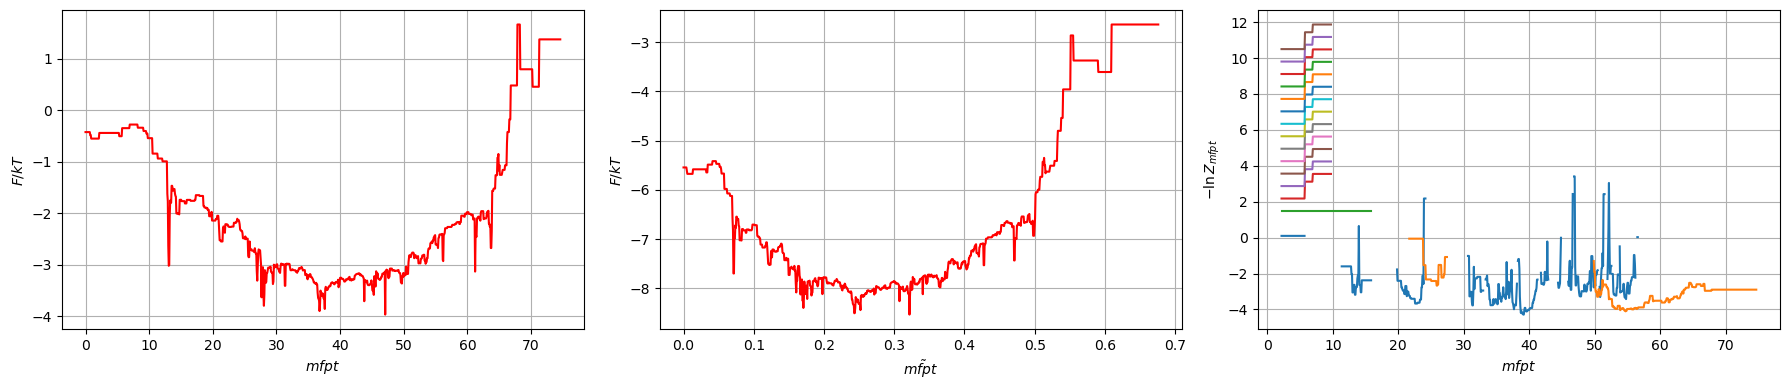

In [30]:
OptimalRCs.envelope_scale=0.01

def comp_y():
    return xtraj[:,np.random.randint(xtraj.shape[1])]

q=OptimalRCs.MFPTNE(IndA=IndA, i_traj=ptrajne, t_traj=ttrajne)
np.random.seed(0)
q.fit_transform(comp_y,dxmin=1e-4, gamma=0.1)
q.plots(dt_sim=0.0005) 
plt.savefig("to death selected individuals with tuned hyperparameters.svg", format='svg', dpi=1200)

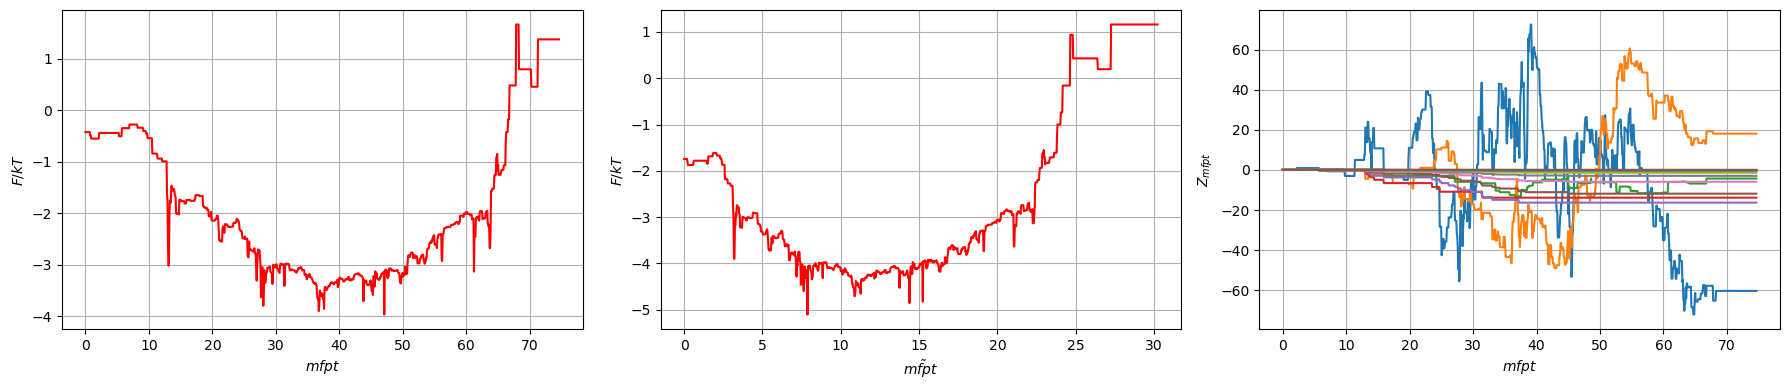

In [338]:
q.plots(lnzmfpt=False)
plt.savefig("to death selected individuals lnzmfpt=False with tuned hyperparameters.svg", format='svg', dpi=1200)

Without adjusting gamma, it would not converge. I can also adjust the envelope scale and ny

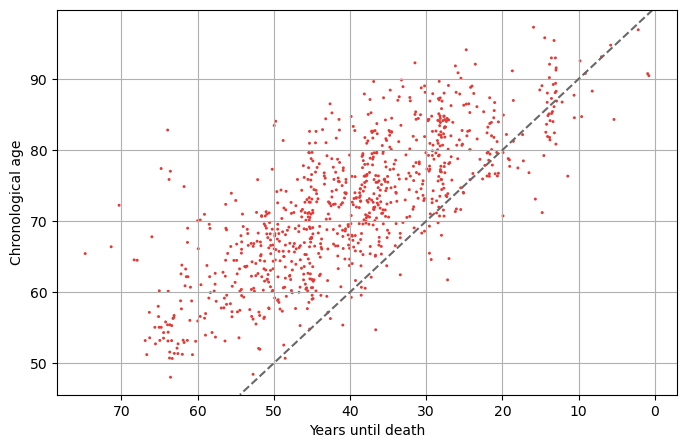

In [31]:
b = q.r
c = ttrajne

# Mask to keep only points that are NOT (0, 100)
mask = ~((b == 0) & (c == 100))

# Apply mask
b_filtered = b[mask]
c_filtered = c[mask]

plt.figure(figsize=(8, 5))
plt.scatter(b_filtered, c_filtered, edgecolor="none",
        s=18, color="#E53935", marker=".")

plt.xlabel("Years until death")
plt.ylabel("Chronological age")
plt.axline((50, 50), slope=-1, linestyle='--', color='dimgrey')
plt.gca().invert_xaxis()
plt.grid(True)
#plt.show()
plt.savefig("mfpt years to death >92 with tuned hyperparameters.svg", format='svg', dpi=1200) 

In [35]:
print("Performance")
print("Pearson r:", pearsonr(np.array(c_filtered), np.array(b_filtered))[0])

Performance
Pearson r: -0.766600209615089


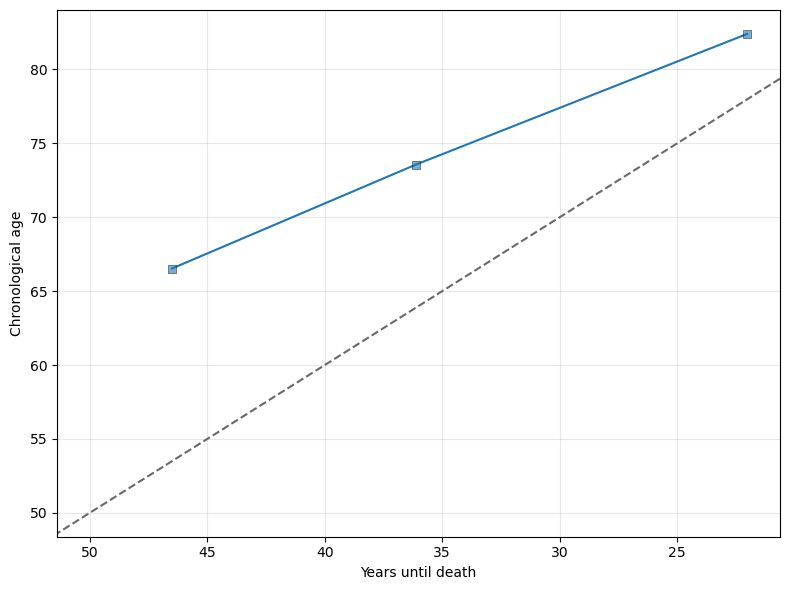

In [340]:
# 25, 54, 55, 79, 90, 102, 104, 107, 119
target_id = 4

# Filter rows for that ID
mask = ptrajne == target_id
subset_biol = b[mask][:-1]   # remove last point
subset_chron = c[mask][:-1] # remove last point

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    subset_biol, subset_chron,
    s=28, marker='s', alpha=0.6, zorder=10,
    edgecolor="black", linewidth=0.5
)
plt.plot(subset_biol, subset_chron,)

plt.xlabel("Years until death")
plt.ylabel("Chronological age")
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
plt.axline((50, 50), slope=-1, linestyle= '--', color='dimgrey')
plt.tight_layout()
plt.show()

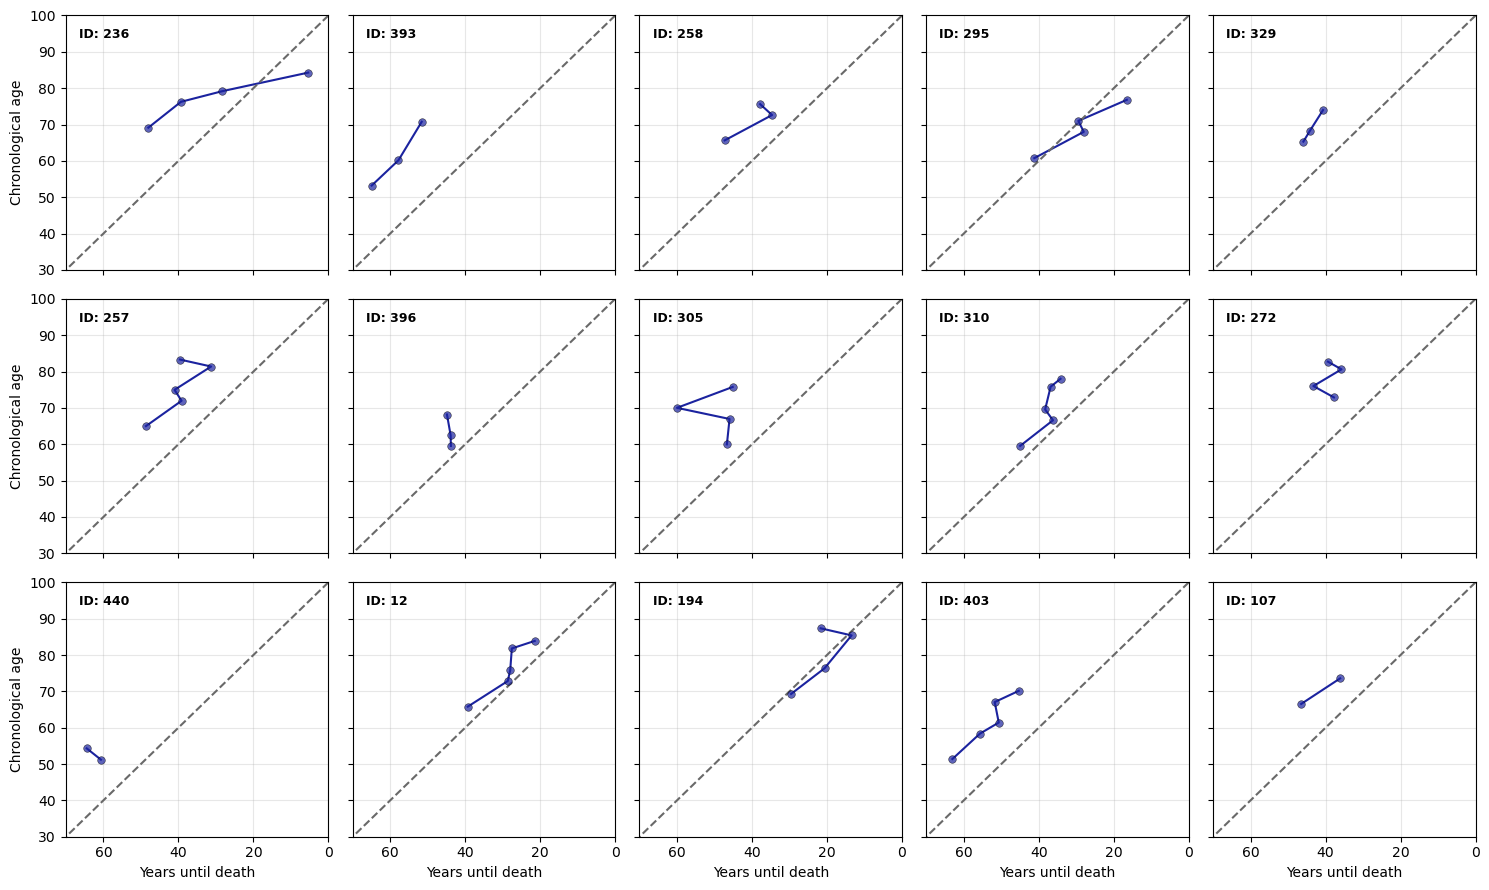

In [341]:
# Set up subplots (e.g., 4x5 grid)
fig, axes = plt.subplots(3, 5, figsize=(15, 9), sharex=True, sharey=True)
axes = axes.flatten()

nrows, ncols = 3, 5

for idx, (ax, target_id) in enumerate(zip(axes, ID_list)):
    # Filter rows for that ID
    mask = ptrajne == target_id
    subset_b = b[mask]
    subset_c = c[mask]

    # Remove final point only for ID 107
    if target_id == 107:
        subset_b = subset_biol[:-1]
        subset_c = subset_chron[:-1]

    # Scatter + line
    ax.scatter(
        subset_b, subset_c,
        s=30, color="#1b239f", marker='o', alpha=0.7, zorder=10,
        edgecolor="black", linewidth=0.4
    )
    ax.plot(subset_b, subset_c, color="#1b239f")

    # Add ID text
    ax.text(
        0.05, 0.95, f"ID: {str(target_id)}", transform=ax.transAxes,
        ha='left', va='top', fontsize=9, weight='bold'
    )
    
    ax.grid(True, alpha=0.3)
    ax.invert_xaxis()
    ax.set_xlim(70, 0)
    ax.set_ylim(30, 100)

    ax.axline((50, 50), slope=-1, linestyle='--', color='dimgrey')

    # Only label leftmost column
    if idx % ncols == 0:
        ax.set_ylabel("Chronological age", fontsize=10)

    # Only label bottom row
    if idx // ncols == nrows - 1:
        ax.set_xlabel("Years until death", fontsize=10)

plt.tight_layout()
#plt.show()
plt.savefig("mfpt time to death >92 vs chronological selected individuals.svg", format='svg', dpi=1200)

ValueError: Shapes (1201,) and (925,) are incompatible

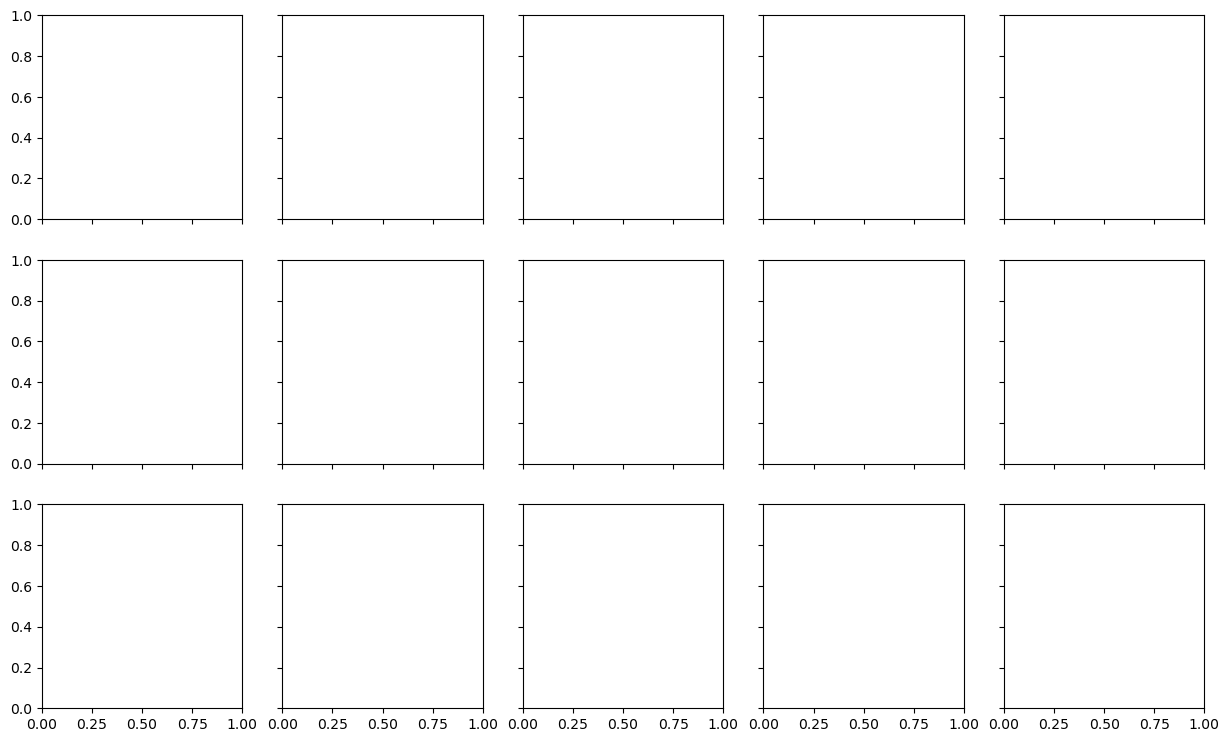

In [342]:
# Set up subplots (3x5 grid)
nrows, ncols = 3, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 9), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (ax, target_id) in enumerate(zip(axes, ID_list)):
    # --- First prediction (red, biol/chron) ---
    mask = ptrajne == target_id
    subset_biol = biol[mask][:-1]   # remove last point
    subset_chron = chron[mask][:-1]
    ax.scatter(subset_biol, subset_chron, s=20, color="#E53935", marker='o', label="Prediction 1")
    ax.plot(subset_biol, subset_chron, color="#E53935")

    # --- Second prediction (blue, b/c) ---
    subset_biol_2 = b[mask]
    subset_chron_2 = c[mask]
    if target_id == 107:  # Remove final point only for ID 107
        subset_biol_2 = subset_biol_2[:-1]
        subset_chron_2 = subset_chron_2[:-1]
    ax.scatter(subset_biol_2, subset_chron_2, s=20, color="#1b239f", marker='o', label="Prediction 2")
    ax.plot(subset_biol_2, subset_chron_2, color="#1b239f")

    # --- Formatting ---
    ax.text(0.05, 0.95, f"ID: {target_id}", transform=ax.transAxes,
            ha='left', va='top', fontsize=9, weight='bold')
    ax.grid(True, alpha=0.3)
    ax.invert_xaxis()
    ax.set_xlim(70, 0)
    ax.set_ylim(30, 100)
    ax.axline((50, 50), slope=-1, linestyle='--', color='dimgrey')

    # Axis labels
    if idx % ncols == 0:
        ax.set_ylabel("Chronological age", fontsize=10)
    if idx // ncols == nrows - 1:
        ax.set_xlabel("Years until death", fontsize=10)

# Remove extra axes (if any)
for ax in axes[len(ID_list):]:
    ax.axis("off")

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()